# Telecom Churn Case Study

## Business Problem Overview
### In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. 
### Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.For many incumbent operators, retaining high profitable customers is the number one business goal. 
### To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Approach
### In this work we have identified the churn customers using the data for " calling"  and "data" usage for the last month. Those with no usage are termed as churned.
### A Logistic Regression based model is built using RFE followed by Lasso regularization for feature selection to identify the most important predictors to help the managers develop strategies to target and retain the probable churn customers.
### To create the model for deployment to identify the possible churn customers. Two seperate models have been built and tested for best recall_score for churn customers.

In [1]:
# Import the required libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
data_1 = pd.read_csv("telecom_churn_data.csv")
data_1.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
#Derive Total Recharge Amount for data

data_1["total_rech_amt_data_6"] = data_1["total_rech_data_6"]  * data_1['av_rech_amt_data_6']
data_1["total_rech_amt_data_7"] = data_1["total_rech_data_7"]  * data_1['av_rech_amt_data_7']
data_1["total_rech_amt_data_8"] = data_1["total_rech_data_8"]  * data_1['av_rech_amt_data_8']
data_1["total_rech_amt_data_9"] = data_1["total_rech_data_9"]  * data_1['av_rech_amt_data_9']

In [5]:
# Drop total_rech_data_* and av_rech_amt_data_*

data_1.drop(["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], axis=1, inplace=True)

## Identifying churn/non-churn customers and creating respective labels

In [6]:
# Check if the attributes for deciding the churn customers have any null values
churn_atr = data_1[["total_ic_mou_9","total_og_mou_9","vol_2g_mb_9","vol_3g_mb_9"]]
print(churn_atr.info())
print(churn_atr.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_ic_mou_9  99999 non-null  float64
 1   total_og_mou_9  99999 non-null  float64
 2   vol_2g_mb_9     99999 non-null  float64
 3   vol_3g_mb_9     99999 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
None
       total_ic_mou_9  total_og_mou_9   vol_2g_mb_9   vol_3g_mb_9
count    99999.000000    99999.000000  99999.000000  99999.000000
mean       189.214260      289.279198     44.719701    136.056613
std        284.823024      468.980002    198.653570    577.394194
min          0.000000        0.000000      0.000000      0.000000
25%         32.370000       25.510000      0.000000      0.000000
50%        105.890000      125.460000      0.000000      0.000000
75%        236.320000      353.480000      0.000000      0.000000
max      10796.590000    11517.730000   8993.9500

The coulumns showing customer activity, over call and data usage have no null values and hence could be used to decide curn and non-churn customers

In [7]:
data_1["churn"] = np.where((data_1["total_ic_mou_9"] == 0) & (data_1["total_og_mou_9"] == 0) & (data_1["vol_2g_mb_9"] == 0) & (data_1["vol_3g_mb_9"] ==0 ), 1,0)


In [8]:
print("Total Churn Customers :", data_1["churn"].sum(),"\n","Total Non-Churn Customers :", data_1["churn"].count() - data_1["churn"].sum(), sep=" ")

Total Churn Customers : 10191 
 Total Non-Churn Customers : 89808


In [9]:
## Removing attributes for the churn month
for i in data_1.columns:
    if i[-1] == "9":
        data_1.drop(i,axis=1,inplace=True)
data_1.shape

(99999, 170)

# 1. Data Cleaning 

## Handling Missing Values

In [10]:
# Identifying columns with missing data and listing other coulumns with missing data
null_columns = []
for i in data_1.columns:
    if data_1[i].isnull().sum()*100/data_1.shape[0]:
        null_columns.append(i)
        print(i, round(data_1[i].isnull().sum()*100/data_1.shape[0],2) )


loc_og_t2o_mou 1.02
std_og_t2o_mou 1.02
loc_ic_t2o_mou 1.02
last_date_of_month_7 0.6
last_date_of_month_8 1.1
onnet_mou_6 3.94
onnet_mou_7 3.86
onnet_mou_8 5.38
offnet_mou_6 3.94
offnet_mou_7 3.86
offnet_mou_8 5.38
roam_ic_mou_6 3.94
roam_ic_mou_7 3.86
roam_ic_mou_8 5.38
roam_og_mou_6 3.94
roam_og_mou_7 3.86
roam_og_mou_8 5.38
loc_og_t2t_mou_6 3.94
loc_og_t2t_mou_7 3.86
loc_og_t2t_mou_8 5.38
loc_og_t2m_mou_6 3.94
loc_og_t2m_mou_7 3.86
loc_og_t2m_mou_8 5.38
loc_og_t2f_mou_6 3.94
loc_og_t2f_mou_7 3.86
loc_og_t2f_mou_8 5.38
loc_og_t2c_mou_6 3.94
loc_og_t2c_mou_7 3.86
loc_og_t2c_mou_8 5.38
loc_og_mou_6 3.94
loc_og_mou_7 3.86
loc_og_mou_8 5.38
std_og_t2t_mou_6 3.94
std_og_t2t_mou_7 3.86
std_og_t2t_mou_8 5.38
std_og_t2m_mou_6 3.94
std_og_t2m_mou_7 3.86
std_og_t2m_mou_8 5.38
std_og_t2f_mou_6 3.94
std_og_t2f_mou_7 3.86
std_og_t2f_mou_8 5.38
std_og_t2c_mou_6 3.94
std_og_t2c_mou_7 3.86
std_og_t2c_mou_8 5.38
std_og_mou_6 3.94
std_og_mou_7 3.86
std_og_mou_8 5.38
isd_og_mou_6 3.94
isd_og_mou_7 3.86

#### We can see a pattern here. The null values for different KPI for same year show same % of null values. Also, the percentage of null values is higher for "data" related KPI fields. Visualizing the two seperately.

In [11]:
# Identifying columns with missing data and listing other coulumns with missing data
null_high = []
null_low = []
for i in data_1.columns:
    if data_1[i].isnull().sum()*100/data_1.shape[0]>70:
        null_high.append(i)
    elif data_1[i].isnull().sum()*100/data_1.shape[0]<70 and data_1[i].isnull().sum()*100/data_1.shape[0]>0:
        null_low.append(i)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 

<AxesSubplot:>

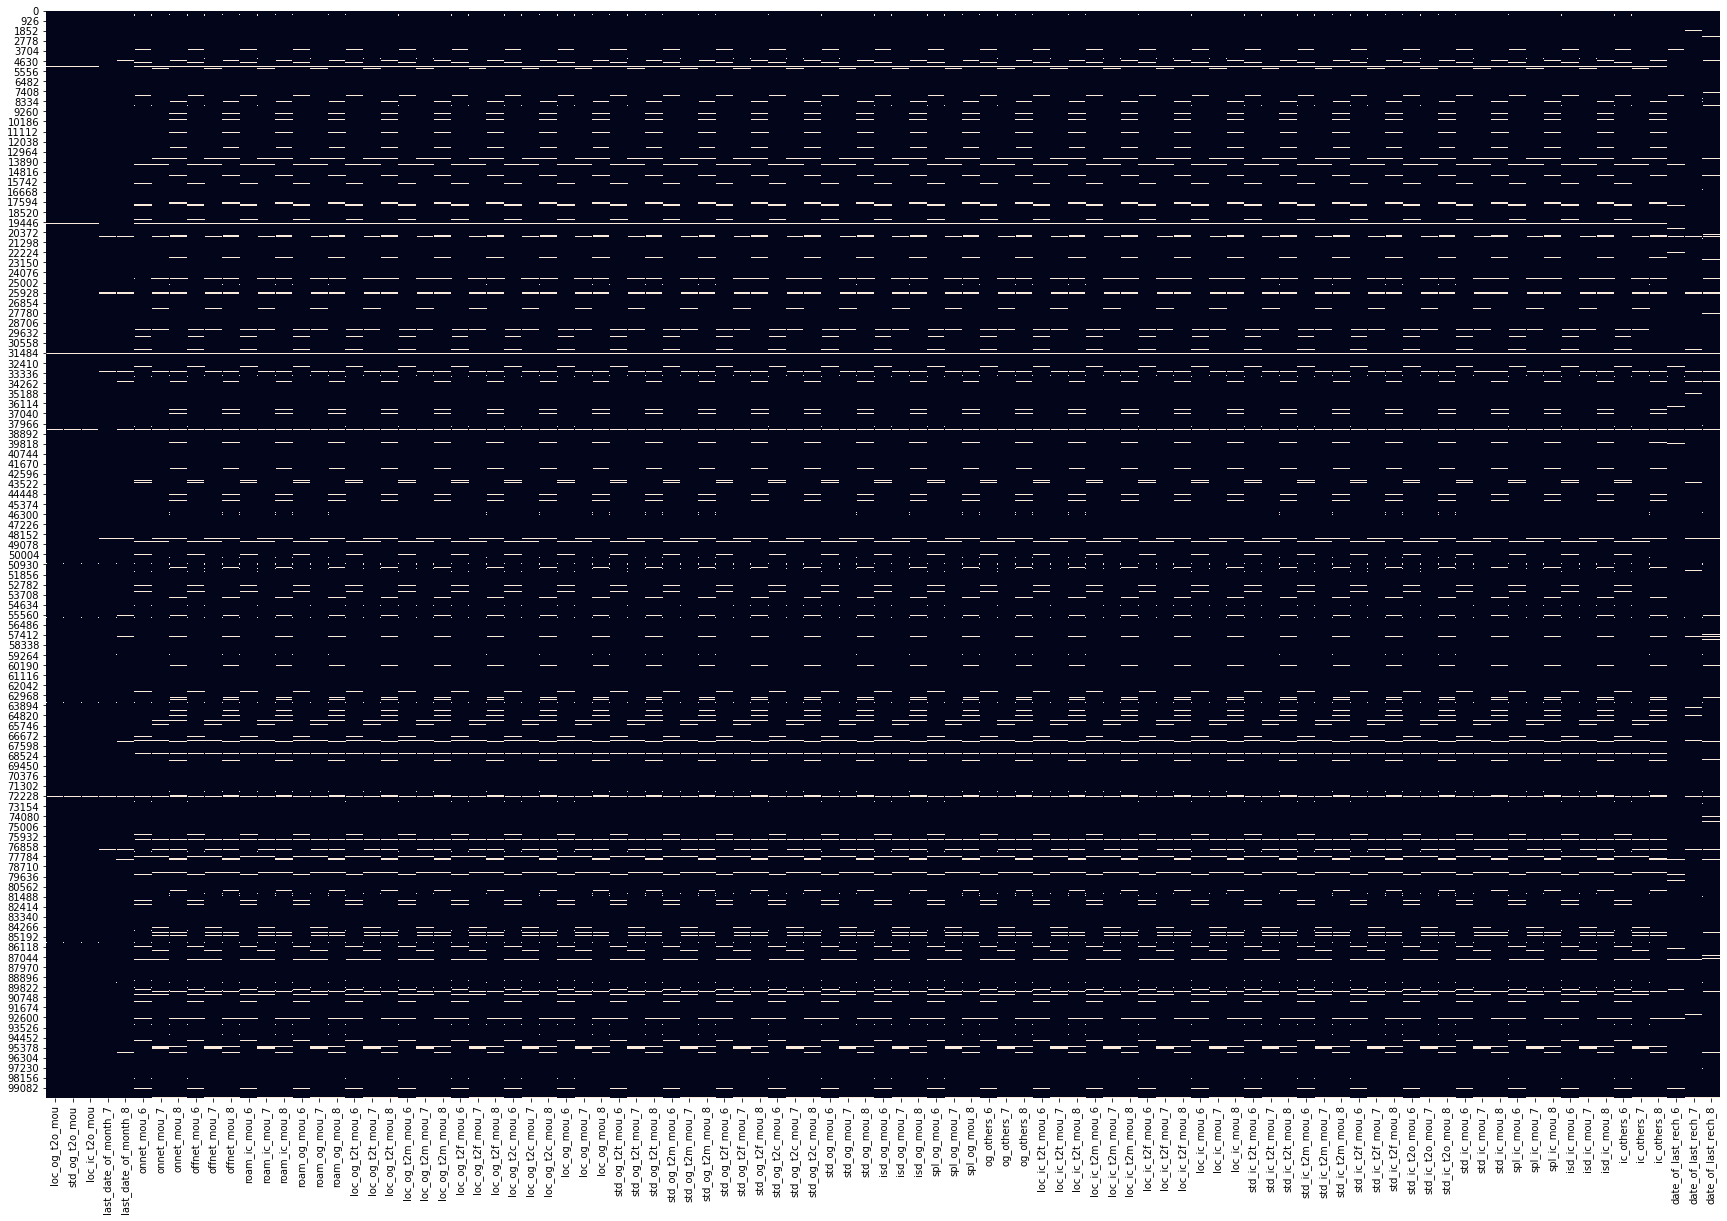

In [12]:
# Columns with low percentage of null values
print(null_low)
plt.figure(figsize =(30,20))
sns.heatmap(data_1[null_low].isnull(),cbar=False)

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_rech_amt_data_8']


<AxesSubplot:>

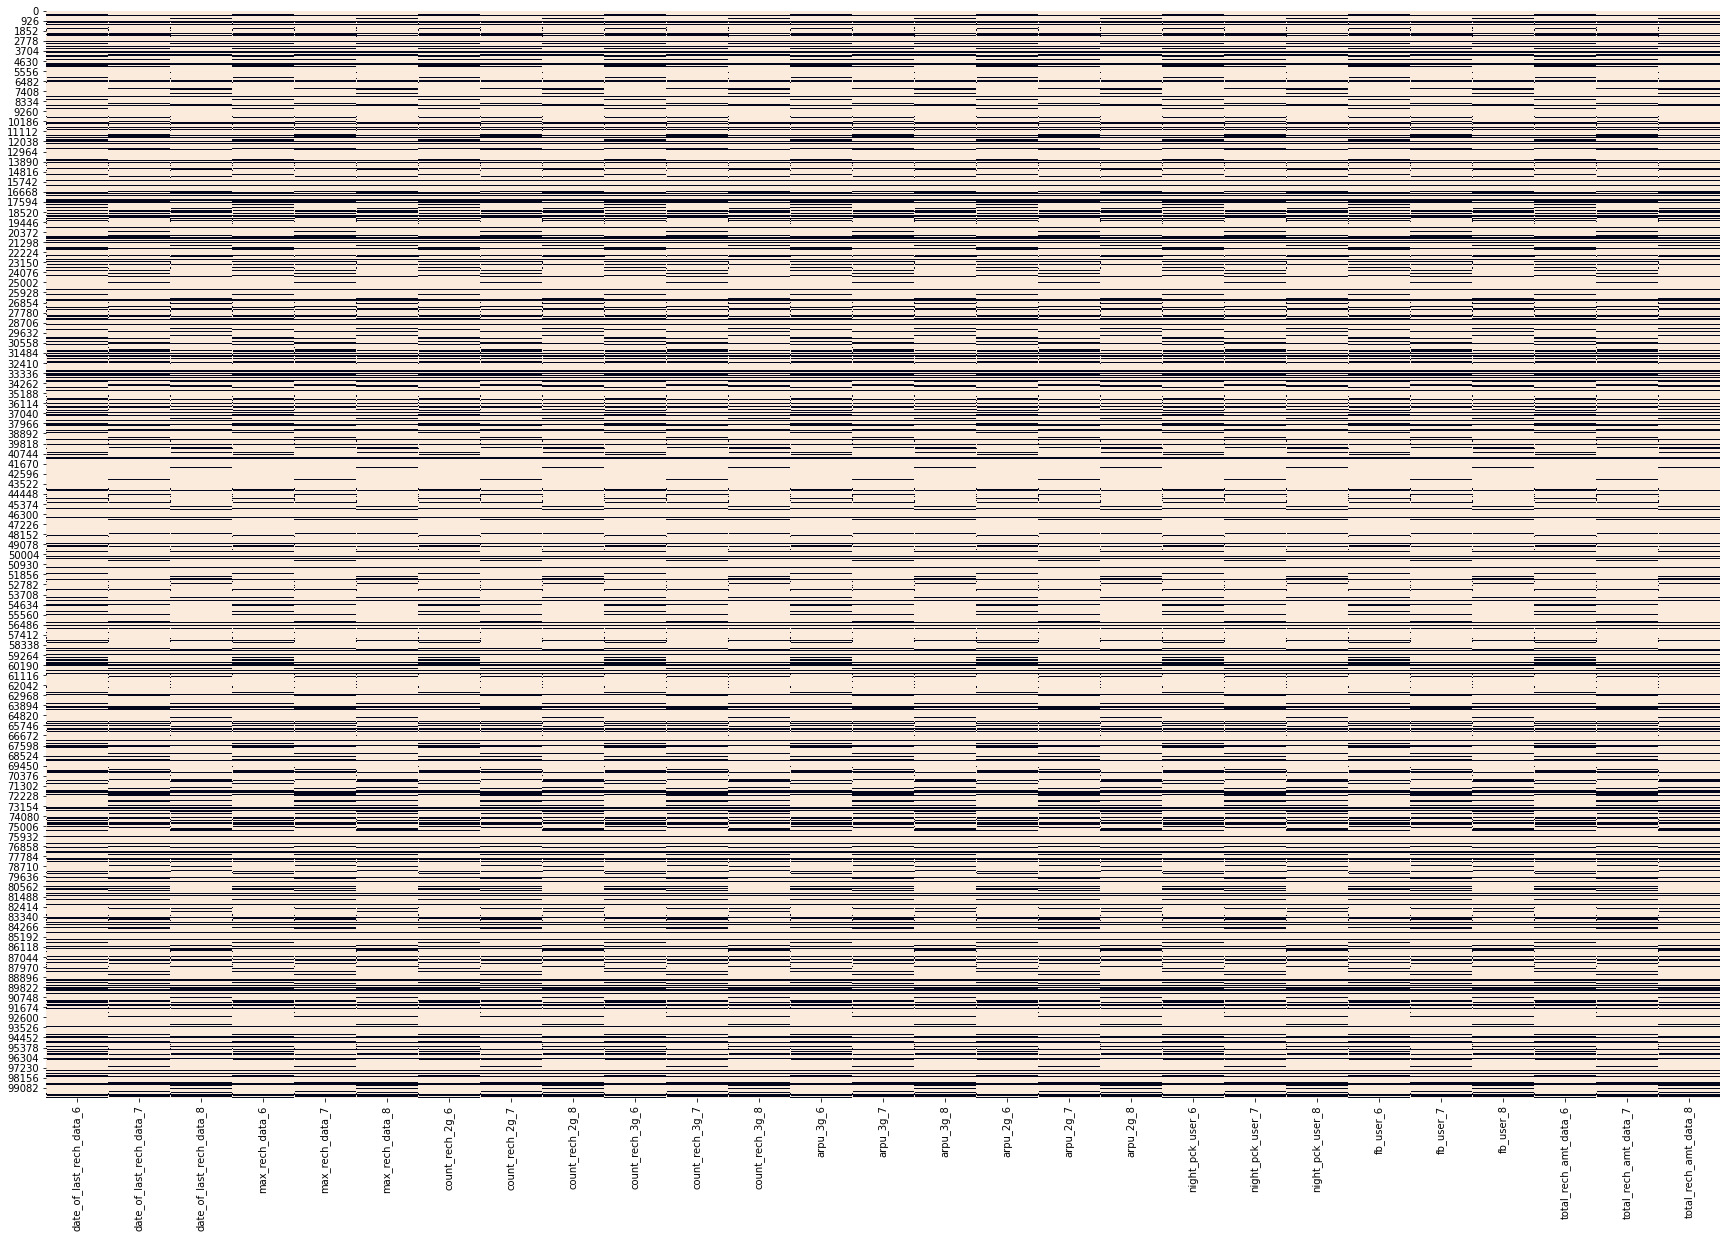

In [13]:
# Columns with high percentage of null values
print(null_high)
plt.figure(figsize =(30,20))
sns.heatmap(data_1[null_high].isnull(),cbar=False)

### - We can see that the null values across columns correspond to same customer. And that they can be braodly divided into two categories i.e. those asscociated with call usage and the other with data usage.
### - There is no difference between 2g and 3g KPI null value %.

In [14]:
# Considering any one of the year-specific phone usage attribute with null values to check calling activity outgoing
print(data_1.loc[data_1["ic_others_6"].isnull(),"total_og_mou_6"].sum()*100/data_1["ic_others_6"].isnull().count())
print(data_1.loc[data_1["ic_others_7"].isnull(),"total_og_mou_7"].sum()*100/data_1["ic_others_7"].isnull().count())
print(data_1.loc[data_1["ic_others_8"].isnull(),"total_og_mou_8"].sum()*100/data_1["ic_others_8"].isnull().count())


0.0
0.0
0.0


In [15]:
# Considering any one of the year specific phone usage attribute with null values to check calling activity incoming
print(data_1.loc[data_1["ic_others_6"].isnull(),"total_ic_mou_6"].sum()*100/data_1["ic_others_6"].isnull().count())
print(data_1.loc[data_1["ic_others_7"].isnull(),"total_ic_mou_7"].sum()*100/data_1["ic_others_7"].isnull().count())
print(data_1.loc[data_1["ic_others_8"].isnull(),"total_ic_mou_8"].sum()*100/data_1["ic_others_8"].isnull().count())


0.0
0.0
0.0


In [16]:
# Considering any one of the year specific data usage attribute with null values to check data usage activity incoming
print(data_1.loc[data_1["arpu_3g_6"].isnull(),"total_rech_amt_data_6"].sum()*100/data_1["arpu_3g_6"].isnull().count())
print(data_1.loc[data_1["arpu_3g_7"].isnull(),"total_rech_amt_data_7"].sum()*100/data_1["arpu_3g_7"].isnull().count())
print(data_1.loc[data_1["arpu_3g_8"].isnull(),"total_rech_amt_data_8"].sum()*100/data_1["arpu_3g_8"].isnull().count())


0.0
0.0
0.0


### Clearly the Null values represent customers not using specific service and they are not "missing data". Hence, the data must be imputed using either "0" for numerical variables and "not recharged" for categorical.

#### For the columns "date_from_last_rech" and "date_from_last_rech_data", 'NA' means No recharge for the month. Changing to date variable to "days from last recharge to end of the month" and imputing NA with Not Recharged 

In [17]:
# function to change the date of last recharge to "days from last recharge to end of the month"
def date_to_days(date):
    
    data_1[date] = pd.to_datetime(data_1[date])

    if date[-1] == "6":
        date_last = pd.to_datetime('20140630', format='%Y%m%d', errors='ignore')
        days = "days_from_last_rech_6"
    elif date[-1] == "7":
        date_last = pd.to_datetime('20140731', format='%Y%m%d', errors='ignore')       
        days = "days_from_last_rech_7"
    elif date[-1] == "8":
        date_last = pd.to_datetime('20140831', format='%Y%m%d', errors='ignore')
        days = "days_from_last_rech_8"
    
            
    data_1[days] = date_last - data_1[date]
    
    bins=[pd.Timedelta(days = 0),
     pd.Timedelta(days = 10),
     pd.Timedelta(days = 20),
     pd.Timedelta(days = 31)]

    range_labels=['<10','10-20','20-31']
    data_1[days]=pd.cut(data_1[days], bins, labels=range_labels)
    
    data_1.drop([date],axis=1,inplace=True)
    
    # Replacing the Nan values in date_of_last rech with Not Recharged
    data_1[days] = data_1[days].cat.add_categories('Not Recharged')
    data_1[days].fillna('Not Recharged', inplace =True)



In [18]:
# Converting the date columns using the defined function
date_to_days("date_of_last_rech_6")
date_to_days("date_of_last_rech_7")
date_to_days("date_of_last_rech_8")


date_to_days("date_of_last_rech_data_6")
date_to_days("date_of_last_rech_data_7")
date_to_days("date_of_last_rech_data_8")



In [19]:
# Verifying the changed columns
data_1["days_from_last_rech_6"]

0                  <10
1        Not Recharged
2        Not Recharged
3        Not Recharged
4                20-31
             ...      
99994    Not Recharged
99995    Not Recharged
99996            10-20
99997            10-20
99998            10-20
Name: days_from_last_rech_6, Length: 99999, dtype: category
Categories (4, object): ['<10' < '10-20' < '20-31' < 'Not Recharged']

In [20]:
### Deleting Last_day of _month column as this doesn't provide any valuable information for the model
data_1.drop(["last_date_of_month_6","last_date_of_month_7","last_date_of_month_8"],axis=1,inplace = True)
data_1.shape

(99999, 164)

In [21]:
# Investigating the "night_pck_user_6" and "fb_user_6" data type
print(data_1["night_pck_user_6"].dtype)
print(data_1["fb_user_6"].dtype)

float64
float64


In [22]:
print(data_1["night_pck_user_6"].value_counts())
print(data_1["fb_user_6"].value_counts())
print(data_1["night_pck_user_7"].value_counts())
print(data_1["fb_user_7"].value_counts())
print(data_1["night_pck_user_8"].value_counts())
print(data_1["fb_user_8"].value_counts())

0.0    24522
1.0      631
Name: night_pck_user_6, dtype: int64
1.0    23000
0.0     2153
Name: fb_user_6, dtype: int64
0.0    24982
1.0      589
Name: night_pck_user_7, dtype: int64
1.0    23238
0.0     2333
Name: fb_user_7, dtype: int64
0.0    25790
1.0      549
Name: night_pck_user_8, dtype: int64
1.0    23463
0.0     2876
Name: fb_user_8, dtype: int64


### We can see that the data for "night_pck_user" and "fb_user" is highly skewed. Also, the imputation of Null values with mode will further skew the data. Hence it is better to drop these columns.

In [23]:
data_1.drop(["night_pck_user_6","night_pck_user_7","night_pck_user_8","fb_user_6","fb_user_7","fb_user_8"],axis=1, inplace=True)
data_1.shape

(99999, 158)

In [26]:
null_columns = []
for i in data_1.columns:
    if data_1[i].isnull().sum()*100/data_1.shape[0]:
        null_columns.append(i)
        print(i, round(data_1[i].isnull().sum()*100/data_1.shape[0],2) )


loc_og_t2o_mou 1.02
std_og_t2o_mou 1.02
loc_ic_t2o_mou 1.02
onnet_mou_6 3.94
onnet_mou_7 3.86
onnet_mou_8 5.38
offnet_mou_6 3.94
offnet_mou_7 3.86
offnet_mou_8 5.38
roam_ic_mou_6 3.94
roam_ic_mou_7 3.86
roam_ic_mou_8 5.38
roam_og_mou_6 3.94
roam_og_mou_7 3.86
roam_og_mou_8 5.38
loc_og_t2t_mou_6 3.94
loc_og_t2t_mou_7 3.86
loc_og_t2t_mou_8 5.38
loc_og_t2m_mou_6 3.94
loc_og_t2m_mou_7 3.86
loc_og_t2m_mou_8 5.38
loc_og_t2f_mou_6 3.94
loc_og_t2f_mou_7 3.86
loc_og_t2f_mou_8 5.38
loc_og_t2c_mou_6 3.94
loc_og_t2c_mou_7 3.86
loc_og_t2c_mou_8 5.38
loc_og_mou_6 3.94
loc_og_mou_7 3.86
loc_og_mou_8 5.38
std_og_t2t_mou_6 3.94
std_og_t2t_mou_7 3.86
std_og_t2t_mou_8 5.38
std_og_t2m_mou_6 3.94
std_og_t2m_mou_7 3.86
std_og_t2m_mou_8 5.38
std_og_t2f_mou_6 3.94
std_og_t2f_mou_7 3.86
std_og_t2f_mou_8 5.38
std_og_t2c_mou_6 3.94
std_og_t2c_mou_7 3.86
std_og_t2c_mou_8 5.38
std_og_mou_6 3.94
std_og_mou_7 3.86
std_og_mou_8 5.38
isd_og_mou_6 3.94
isd_og_mou_7 3.86
isd_og_mou_8 5.38
spl_og_mou_6 3.94
spl_og_mou_7 

In [27]:
### Imputing null values with 0

for i in null_columns:
    data_1.loc[data_1[i].isnull(),i] = 0
for i in data_1.columns:
    if data_1[i].isnull().sum()*100/data_1.shape[0]:
        null_columns.append(i)
        print(i, round(data_1[i].isnull().sum()*100/data_1.shape[0],2) ) 

In [28]:
# Also dropping the mobile Number and circle id columns
data_1.drop(["mobile_number","circle_id"],axis=1,inplace=True)

# New Feature creation

### Average amount per recharge

In [29]:
# Identifying columns with total in the name
tot = [i for i in data_1.columns if 'total' in i]

In [30]:
print(tot)

['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_data_6', 'total_rech_amt_data_7', 'total_rech_amt_data_8']


In [31]:
data_1[tot].describe()

,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,305.133424,310.231175,304.119513,200.130037,202.853055,198.750783,7.558806,7.700367,7.212912,327.514615,322.962970,324.157122,148.883796,171.294755,174.701228
std,463.419481,480.031178,478.150031,291.651671,298.124954,289.321094,7.078405,7.070422,7.203753,398.019701,408.114237,416.540455,804.258761,843.284525,945.517662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.740000,43.010000,38.580000,38.530000,41.190000,38.290000,3.000000,3.000000,3.000000,109.000000,100.000000,90.000000,0.000000,0.000000,0.000000
50%,145.140000,141.530000,138.610000,114.740000,116.340000,114.660000,6.000000,6.000000,5.000000,230.000000,220.000000,225.000000,0.000000,0.000000,0.000000
75%,372.860000,378.570000,369.900000,251.670000,250.660000,248.990000,9.000000,10.000000,9.000000,437.500000,428.000000,434.500000,13.000000,17.000000,23.000000
max,10674.030000,11365.310000,14043.060000,7716.140000,9699.010000,10830.380000,307.000000,138.000000,196.000000,35190.000000,40335.000000,45320.000000,105644.000000,55080.000000,89106.500000


In [32]:
data_1["av_amt_per_rech_6"] = data_1['total_rech_amt_6']/data_1['total_rech_num_6']
data_1["av_amt_per_rech_7"] = data_1['total_rech_amt_7']/data_1['total_rech_num_7']
data_1["av_amt_per_rech_8"] = data_1['total_rech_amt_8']/data_1['total_rech_num_8']


In [33]:
# In cases where the 'total_rech_amt' and 'total_rech_num' are zero, There will be a divide by zero errror
# 'av_amt_per_rech' is replaced with zero. 
av_amt = ["av_amt_per_rech_6","av_amt_per_rech_7","av_amt_per_rech_8"]
for i in av_amt:
    data_1.loc[data_1[i].isnull(),i] = 0

In [34]:
## Changing name of VBC columns to the common identification
data_1.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

### Checking for skewed columns and dropping them

In [35]:
# Finding the columns with skewed data lisitng the % of count of highest count value 
parameters = list(data_1.columns)
skewed = pd.DataFrame()

for i in enumerate(parameters[:]):
    data = {"parameter":i[1],"MaxUniquevalue":(data_1[i[1]].value_counts()*100/data_1[i[1]].count()).max()}
    skewed = skewed.append(data,True)
    
skewed


,MaxUniquevalue,parameter
0,100.000000,loc_og_t2o_mou
1,100.000000,std_og_t2o_mou
2,100.000000,loc_ic_t2o_mou
3,3.731037,arpu_6
4,3.862039,arpu_7
...,...,...
154,76.241762,days_from_last_rech_7
155,75.658757,days_from_last_rech_8
156,11.195112,av_amt_per_rech_6
157,11.792118,av_amt_per_rech_7


In [36]:
# Dropping the columns with highly skewed data
data_1.drop(skewed.parameter[skewed.MaxUniquevalue>90], axis=1,inplace=True)

In [37]:
data_1.shape

(99999, 132)

## Filtering out high value customers

956.0


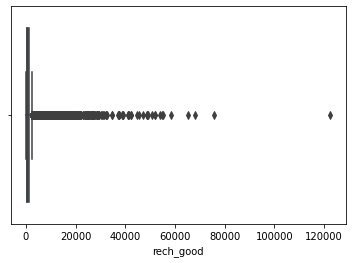

In [38]:
# Filtering the customers with total average recharge during the good years more than 70th percentile
data_1["rech_good"] = data_1["total_rech_amt_6"] + data_1["total_rech_amt_data_6"] +data_1["total_rech_amt_7"] + data_1["total_rech_amt_data_7"]

percentile_70 = np.percentile(data_1["rech_good"], 70.0)
print(percentile_70)
data = data_1[data_1["rech_good"] >= percentile_70]

sns.boxplot((data_1['rech_good']))
data.drop("rech_good",axis=1,inplace=True)

In [39]:
# Capping the outliers to 2 and 98 percetile

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Identifying columns with numeric data

data_numeric = data.select_dtypes(include = numerics)

for col in data_numeric:
    percentiles = data[col].quantile([0.02,0.98]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

# 2. EDA

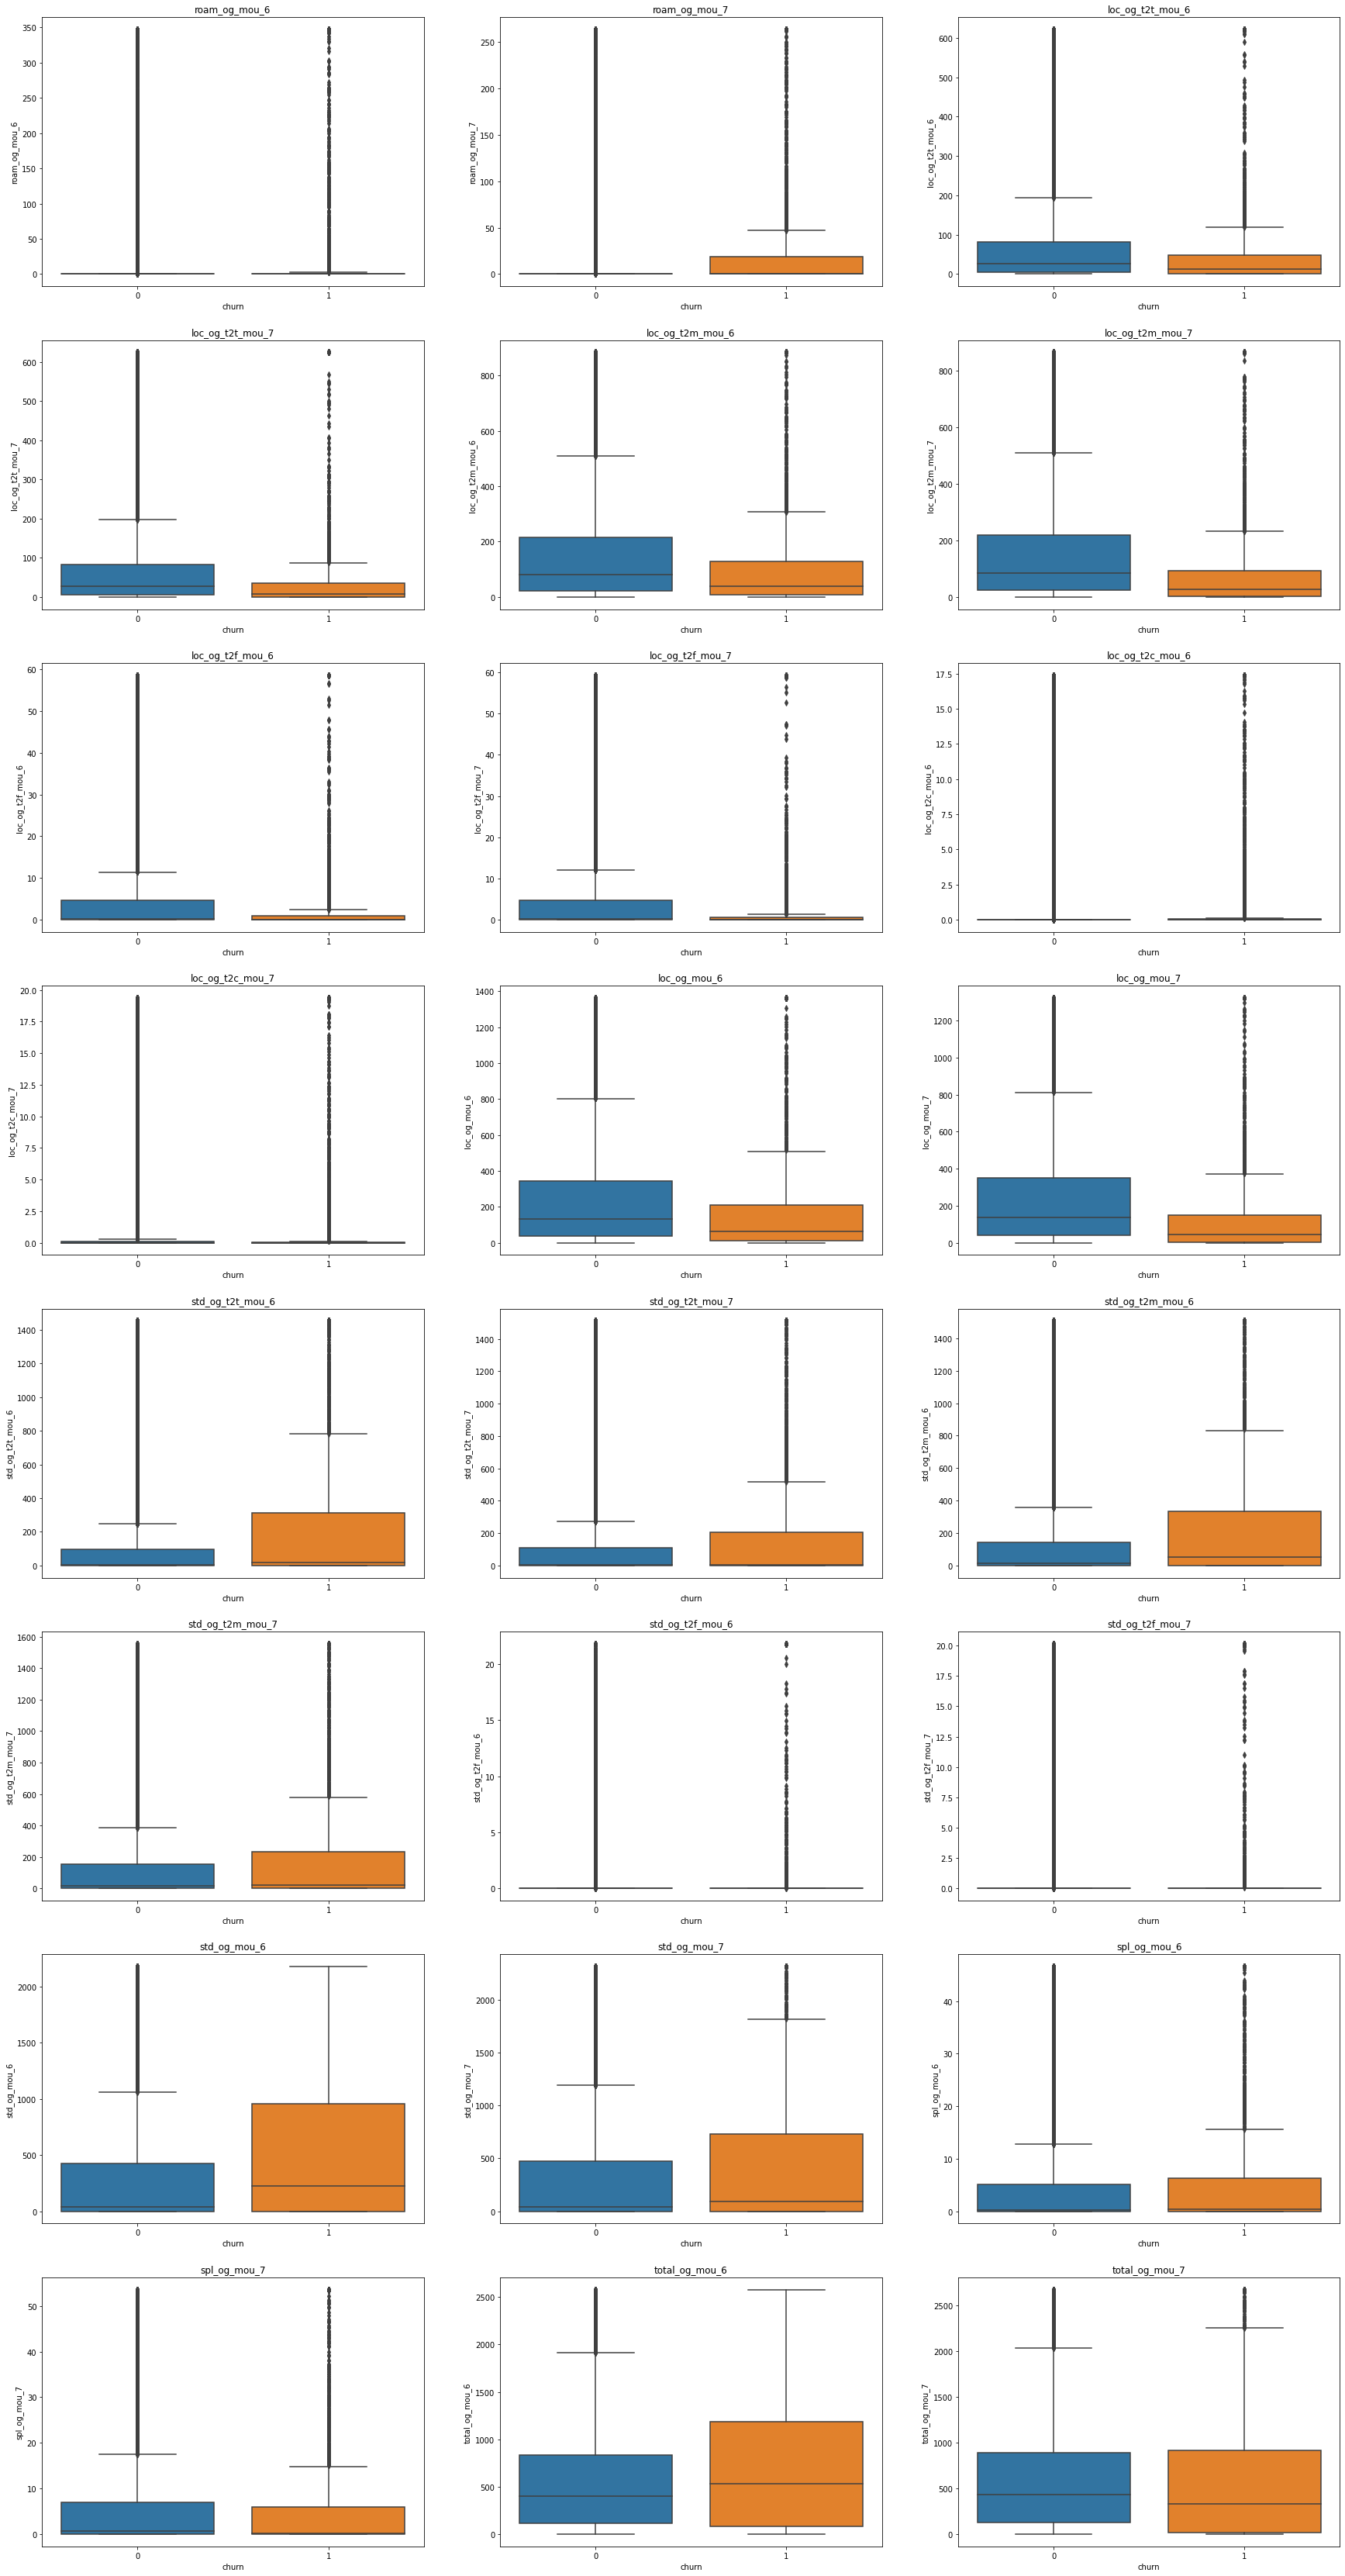

In [40]:
# Relation between minutes of usage and customer churning for the good months
# Attributes with mou outgoing
mou_og_gt = [i for i in data.columns if ("og" in i and "mou" in i and "_8" not in i )]

fig, axes = plt.subplots(nrows=8, ncols = 3, figsize=(30,60))

for i in range(8):
    for j in range(3):
        if i*3 +j < len(mou_og_gt):
            sns.boxplot(x = "churn", y = mou_og_gt[i*3 +j], data=data, ax= axes[i][j])
          
            axes[i][j].set_title(mou_og_gt[i*3 +j])

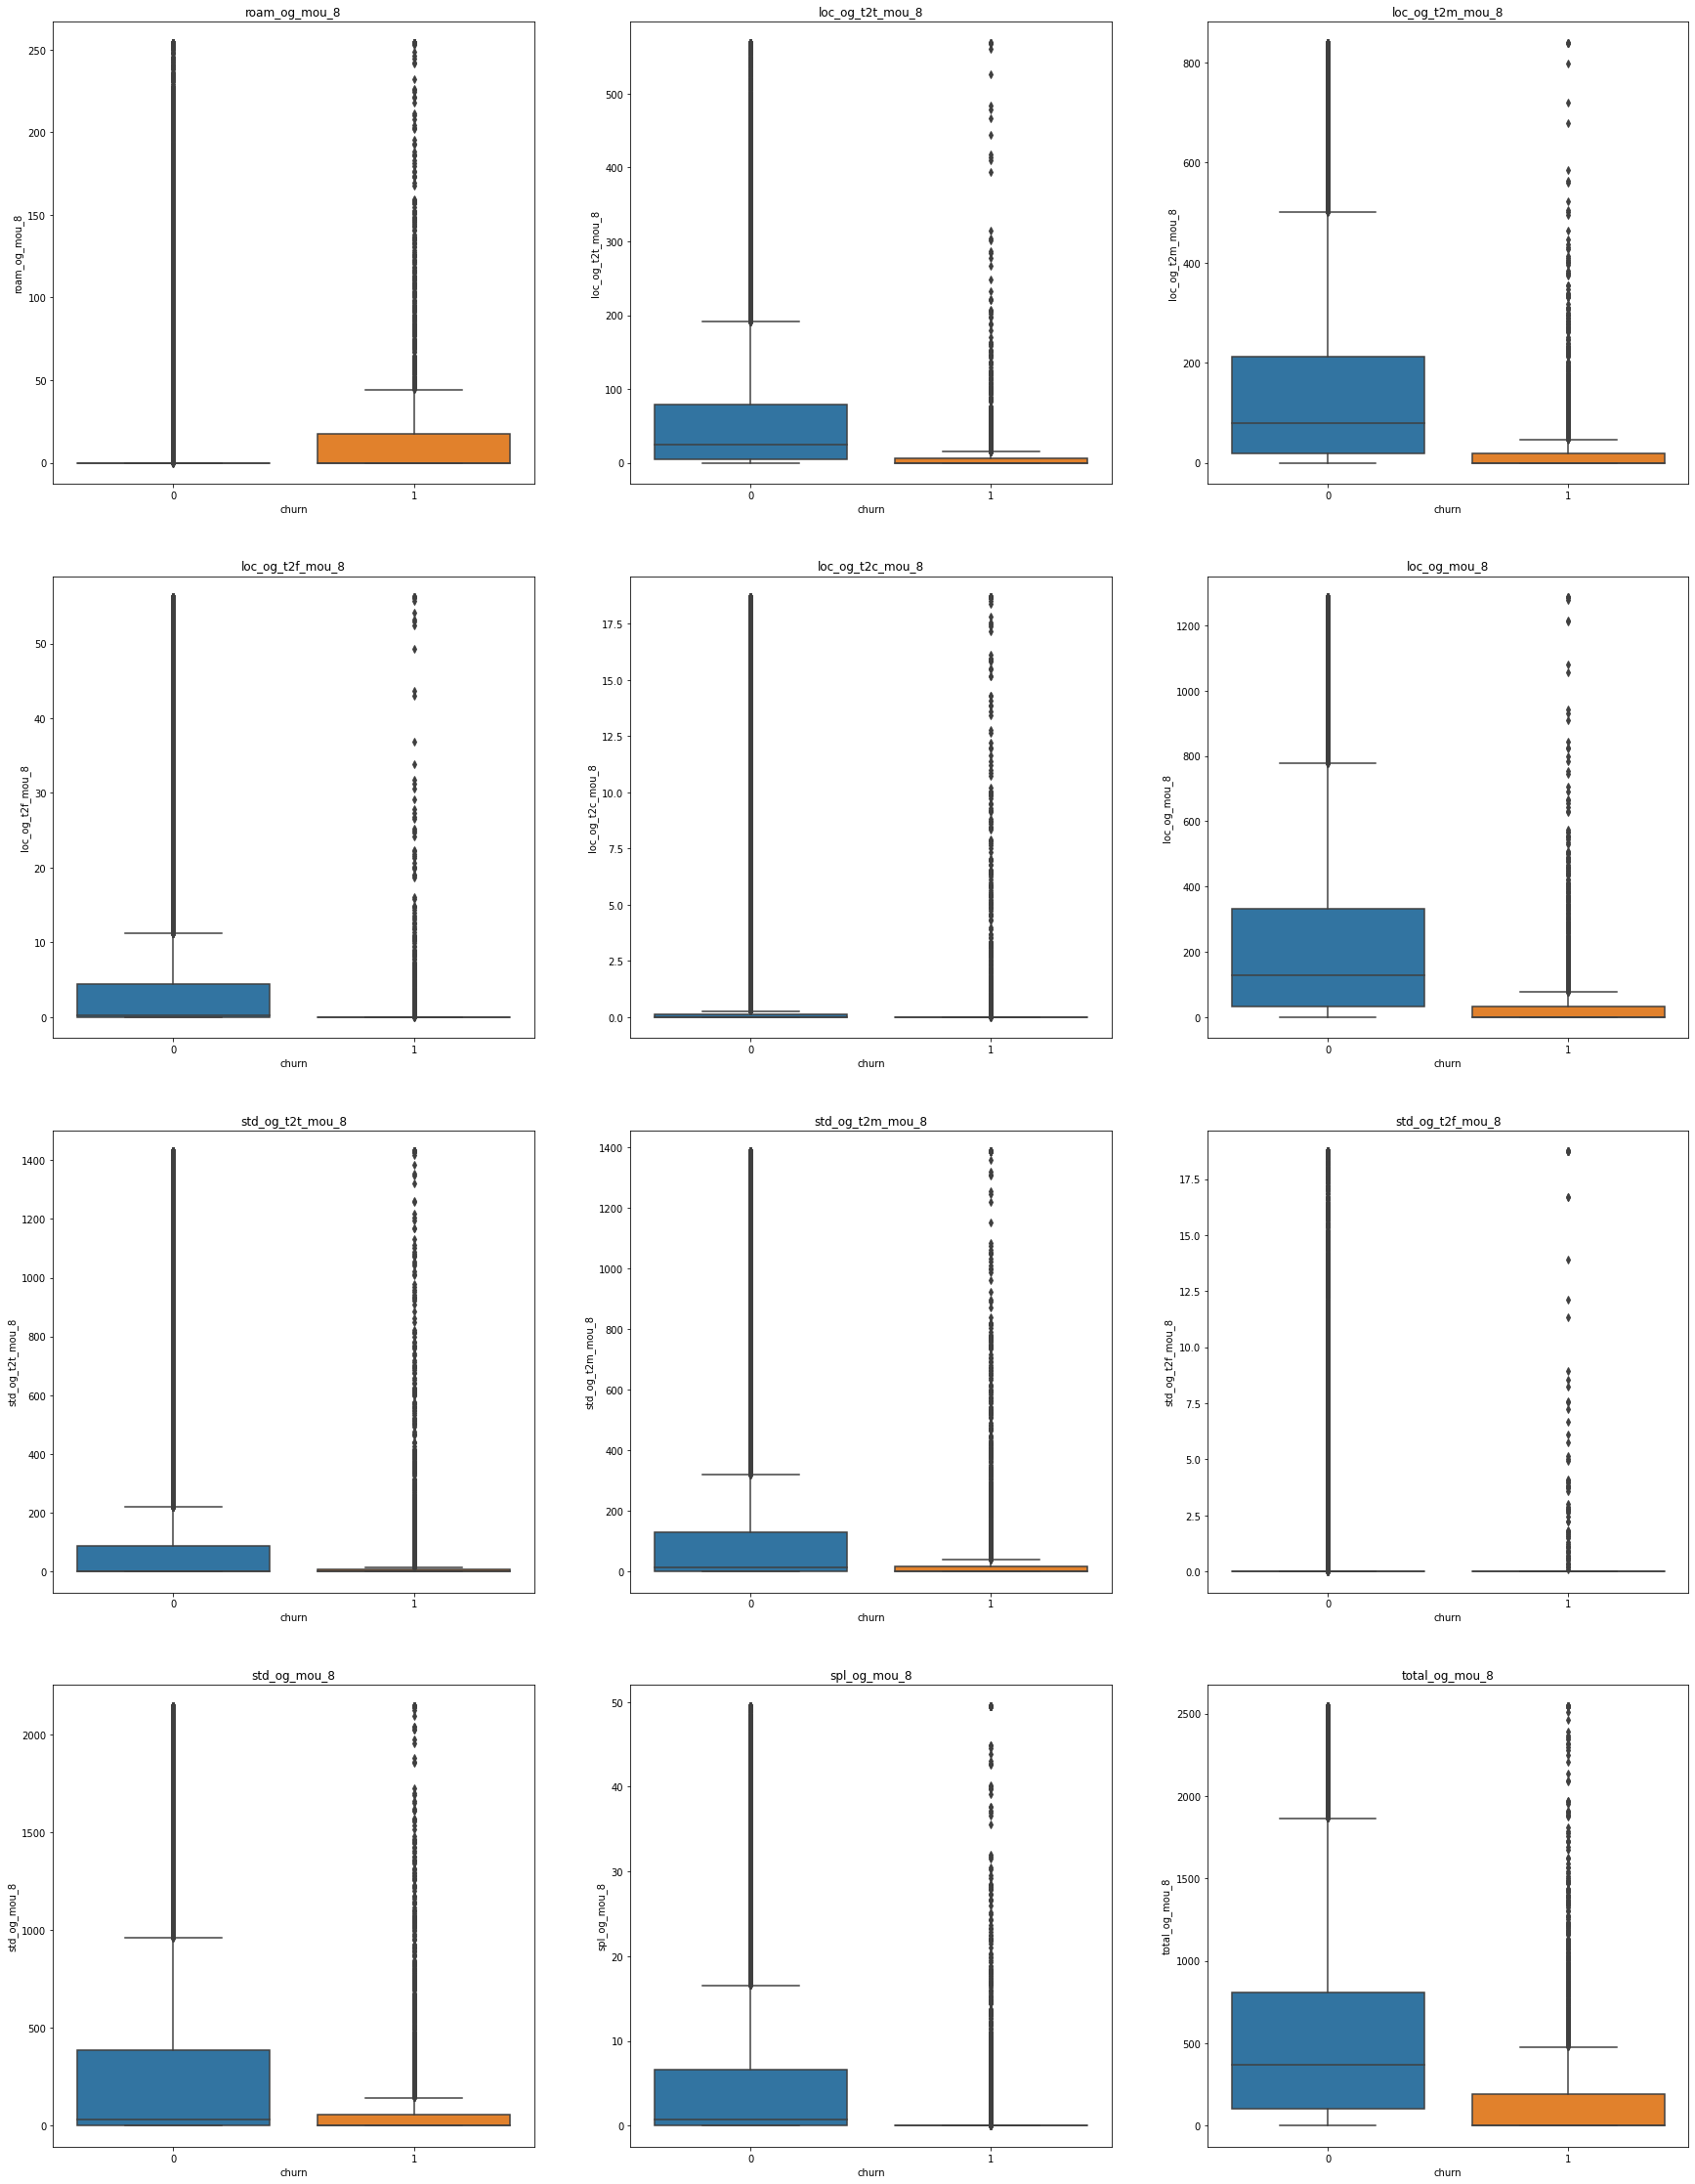

In [41]:
# Relation between minutes of usage and customer churning for the action month
# Attributes with mou outgoing
mou_og_8 = [i for i in data.columns if ("og" in i and "mou" in i and "_8" in i )]

fig, axes = plt.subplots(nrows=4, ncols = 3, figsize=(30,40))

for i in range(4):
    for j in range(3):
        if i*3 +j < len(mou_og_8):
            sns.boxplot(x = "churn", y = mou_og_8[i*3 +j], data=data, ax= axes[i][j])
          
            axes[i][j].set_title(mou_og_8[i*3 +j])

In [42]:
mou_og = mou_og_gt+mou_og_8
mou_og.append("churn")

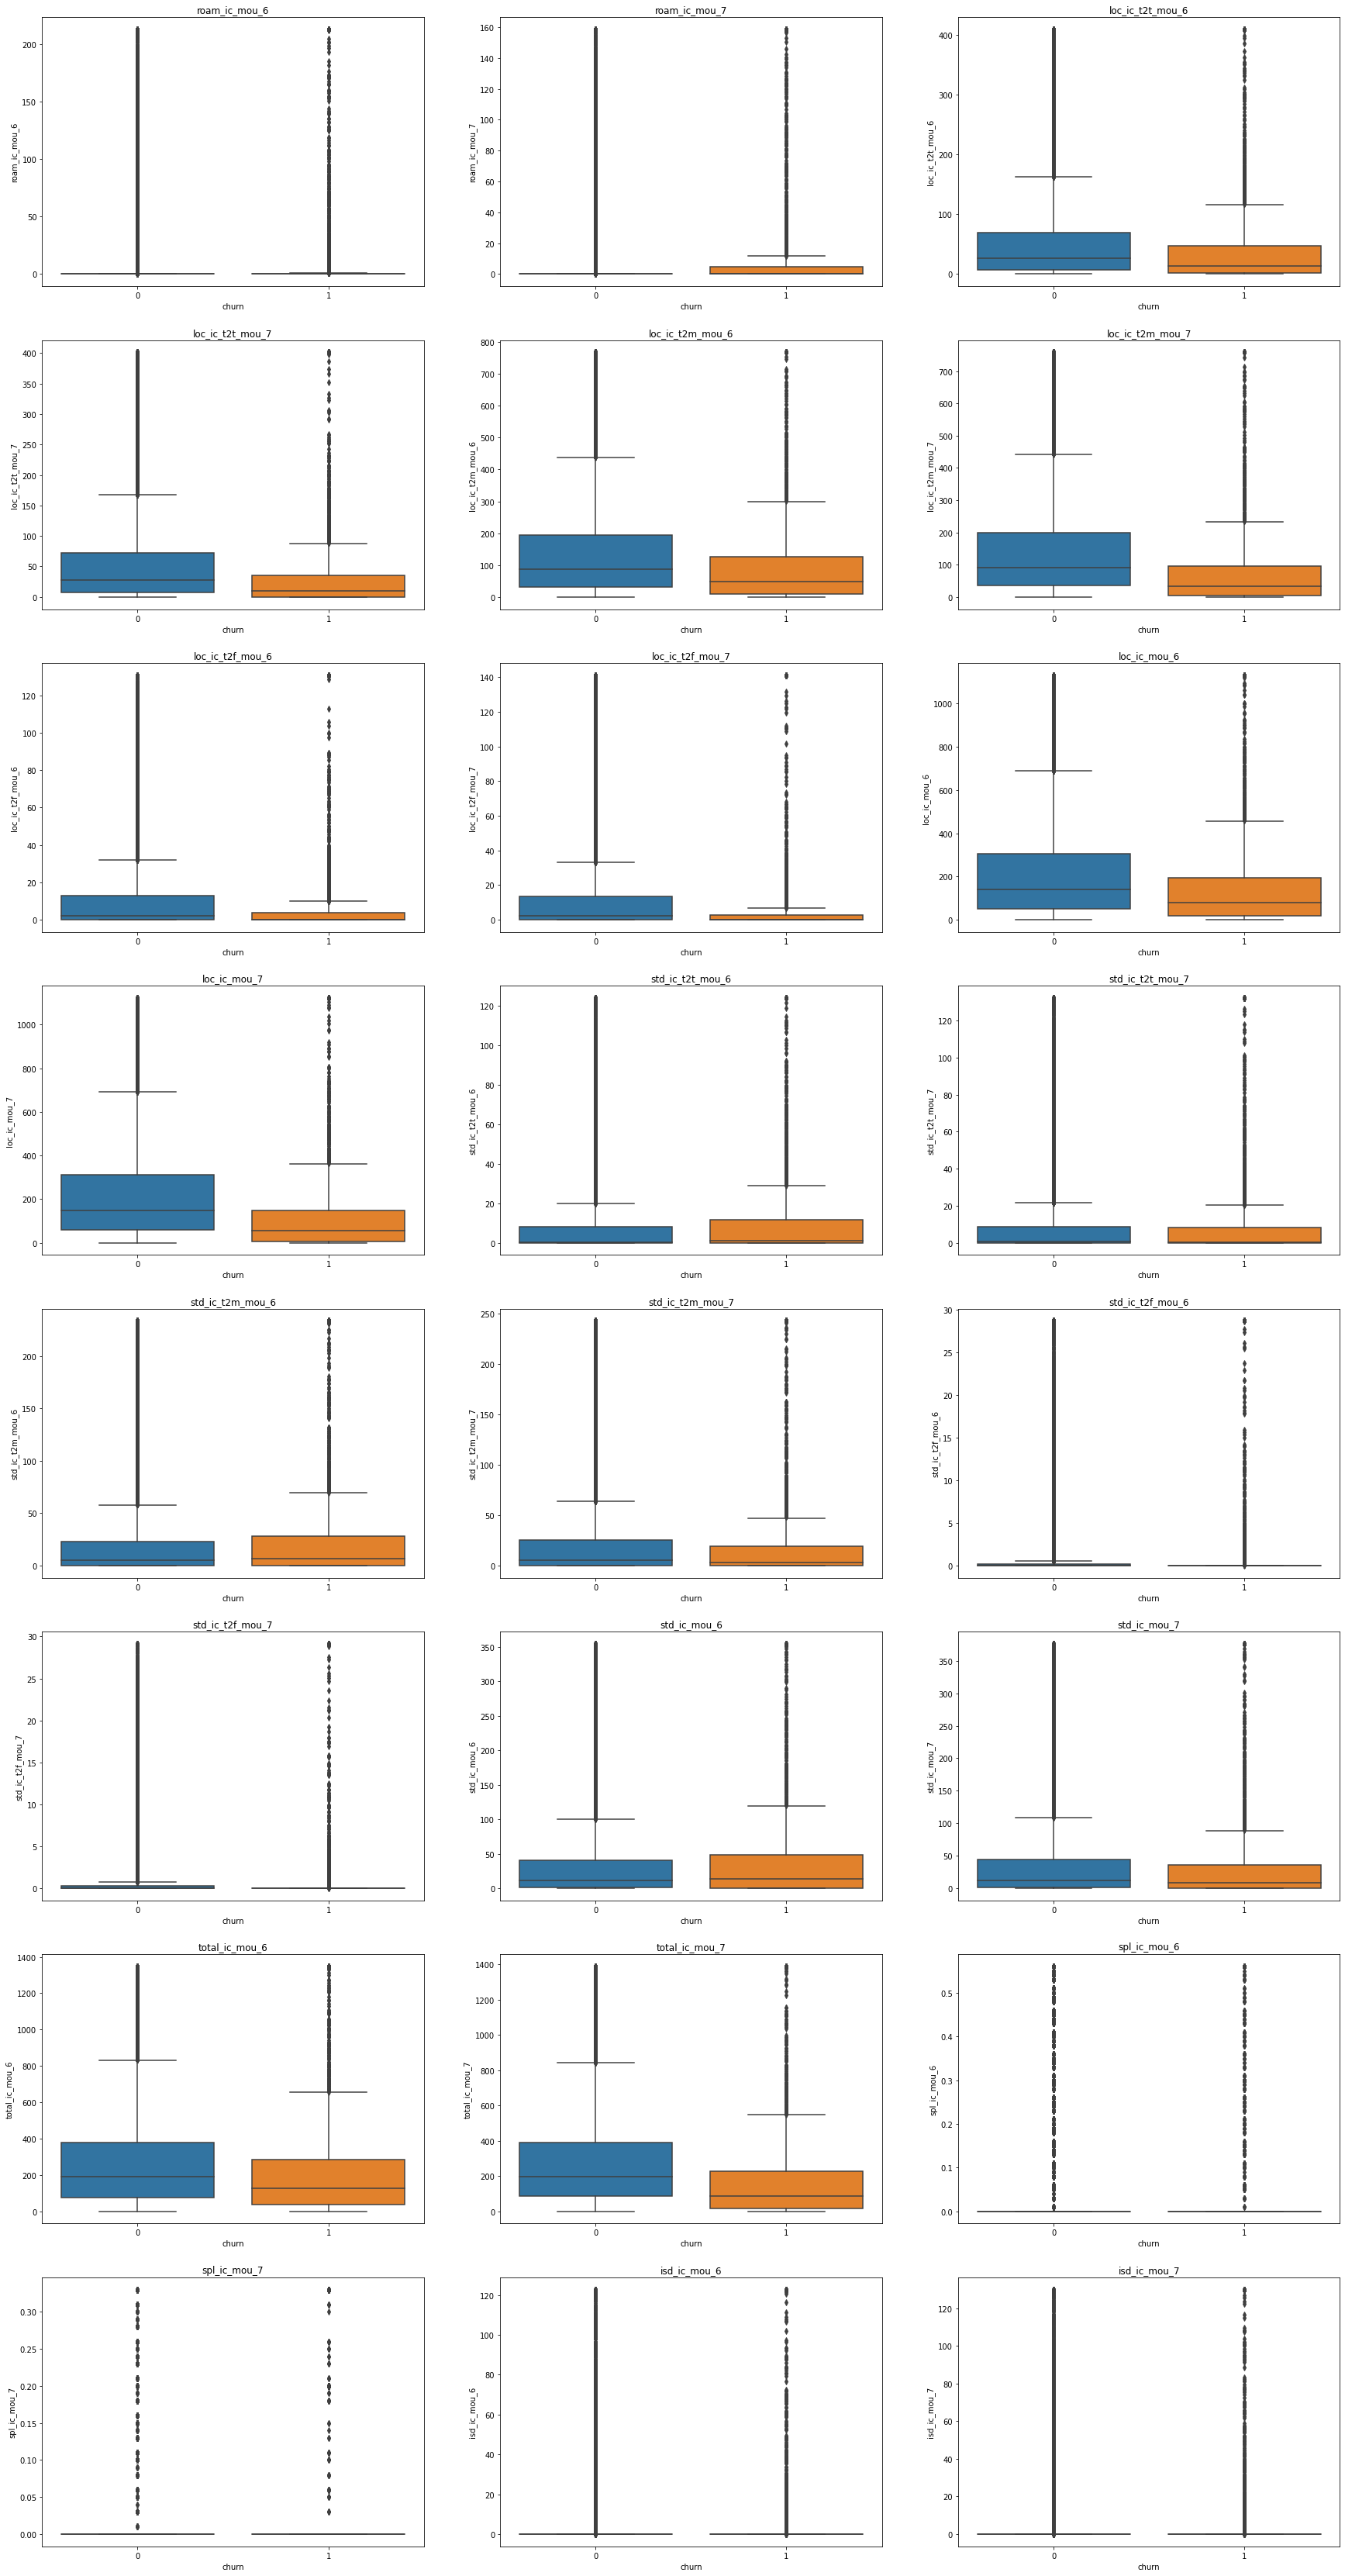

In [43]:
# Relation between minutes of usage and customer churning for the good months
# Attributes with mou incoming
mou_ic_gt = [i for i in data.columns if ("ic" in i and "mou" in i and "_8" not in i)]

fig, axes = plt.subplots(nrows=8, ncols = 3, figsize=(30,60))

for i in range(8):
    for j in range(3):
        if i*3 +j < len(mou_ic_gt):
            sns.boxplot(x = "churn", y = mou_ic_gt[i*3 +j], data=data, ax= axes[i][j])
         
            axes[i][j].set_title(mou_ic_gt[i*3 +j])

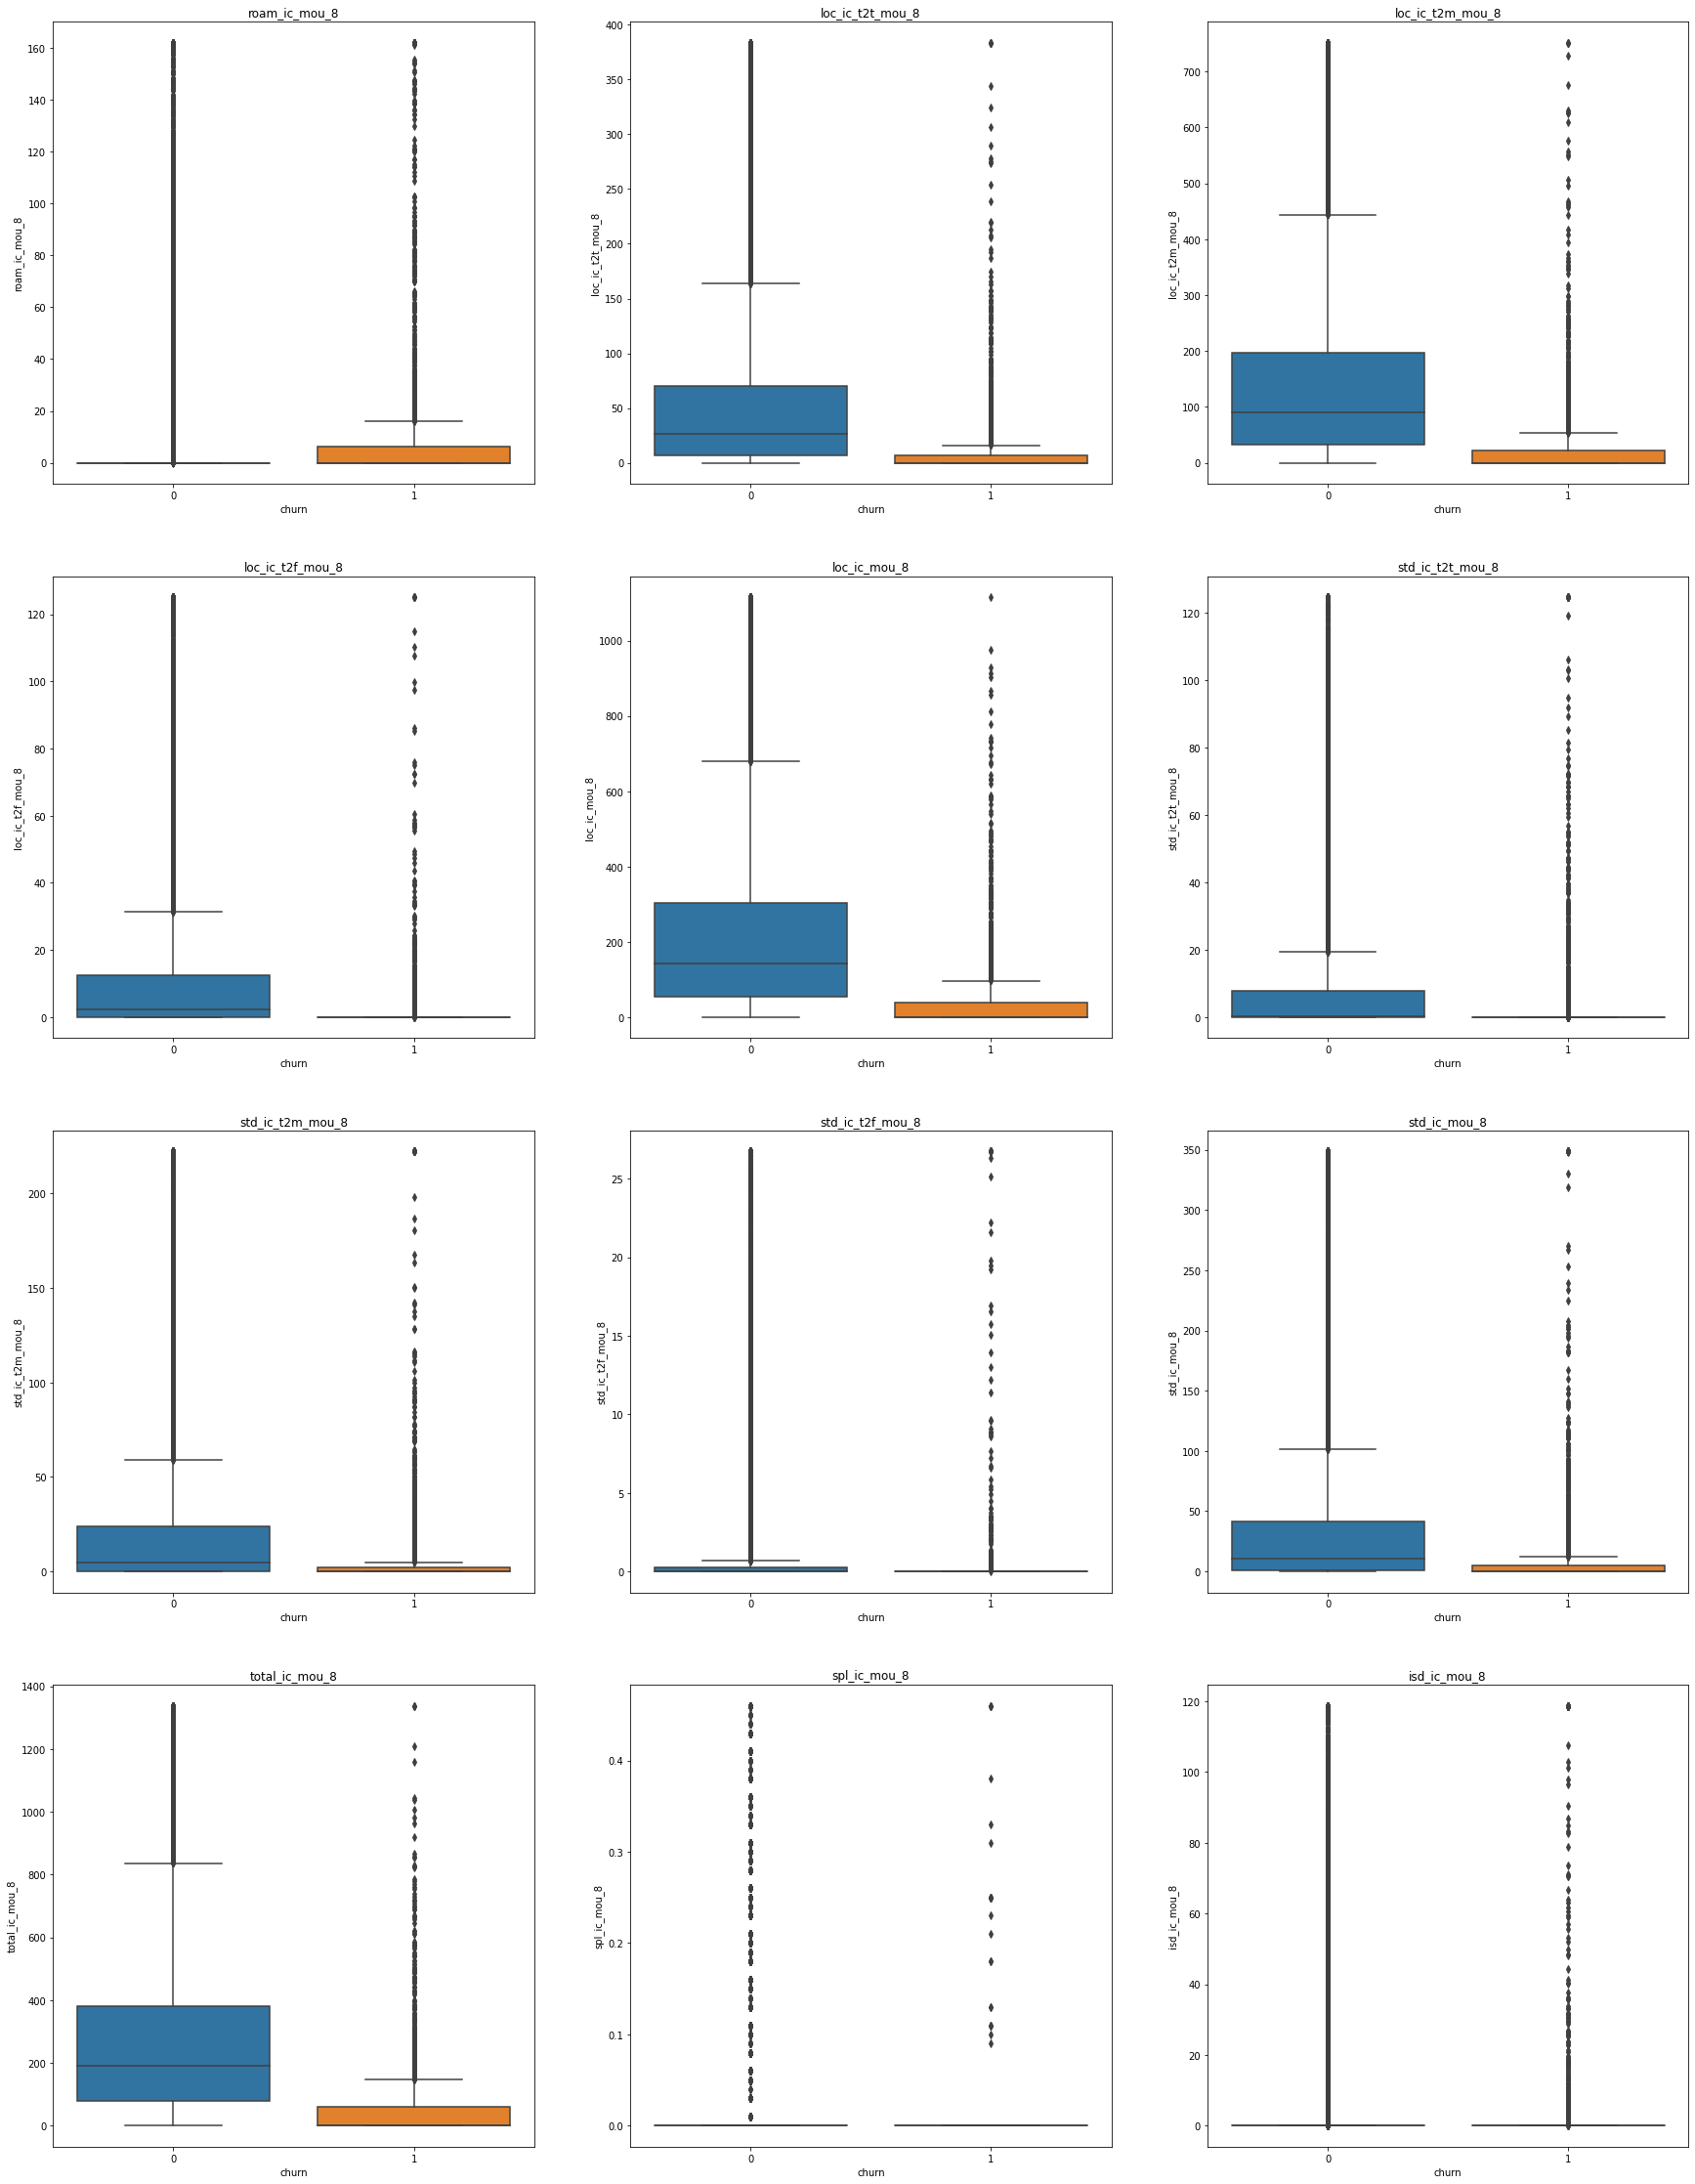

In [44]:
# Relation between minutes of usage and customer churning for the action month
# Attributes with mou incoming
mou_ic_8 = [i for i in data.columns if ("ic" in i and "mou" in i and "_8" in i)]

fig, axes = plt.subplots(nrows=4, ncols = 3, figsize=(30,40))

for i in range(4):
    for j in range(3):
        if i*3 +j < len(mou_ic_8):
            sns.boxplot(x = "churn", y = mou_ic_8[i*3 +j], data=data, ax= axes[i][j])
         
            axes[i][j].set_title(mou_ic_8[i*3 +j])

In [45]:
mou_ic = mou_ic_gt+mou_ic_8
mou_ic.append("churn")

### - We could see that there are several attributes with only one value and hence 0 variance. These columns wont contribute any information to the model and better be dropped.
### - Generally the "potential churn customers" are having lower Minutes of usage across attributes. But, it is not a rule and no substantial conclusion could be drawn.
### - The usage drops considerably for the churn customers from good months to the action month

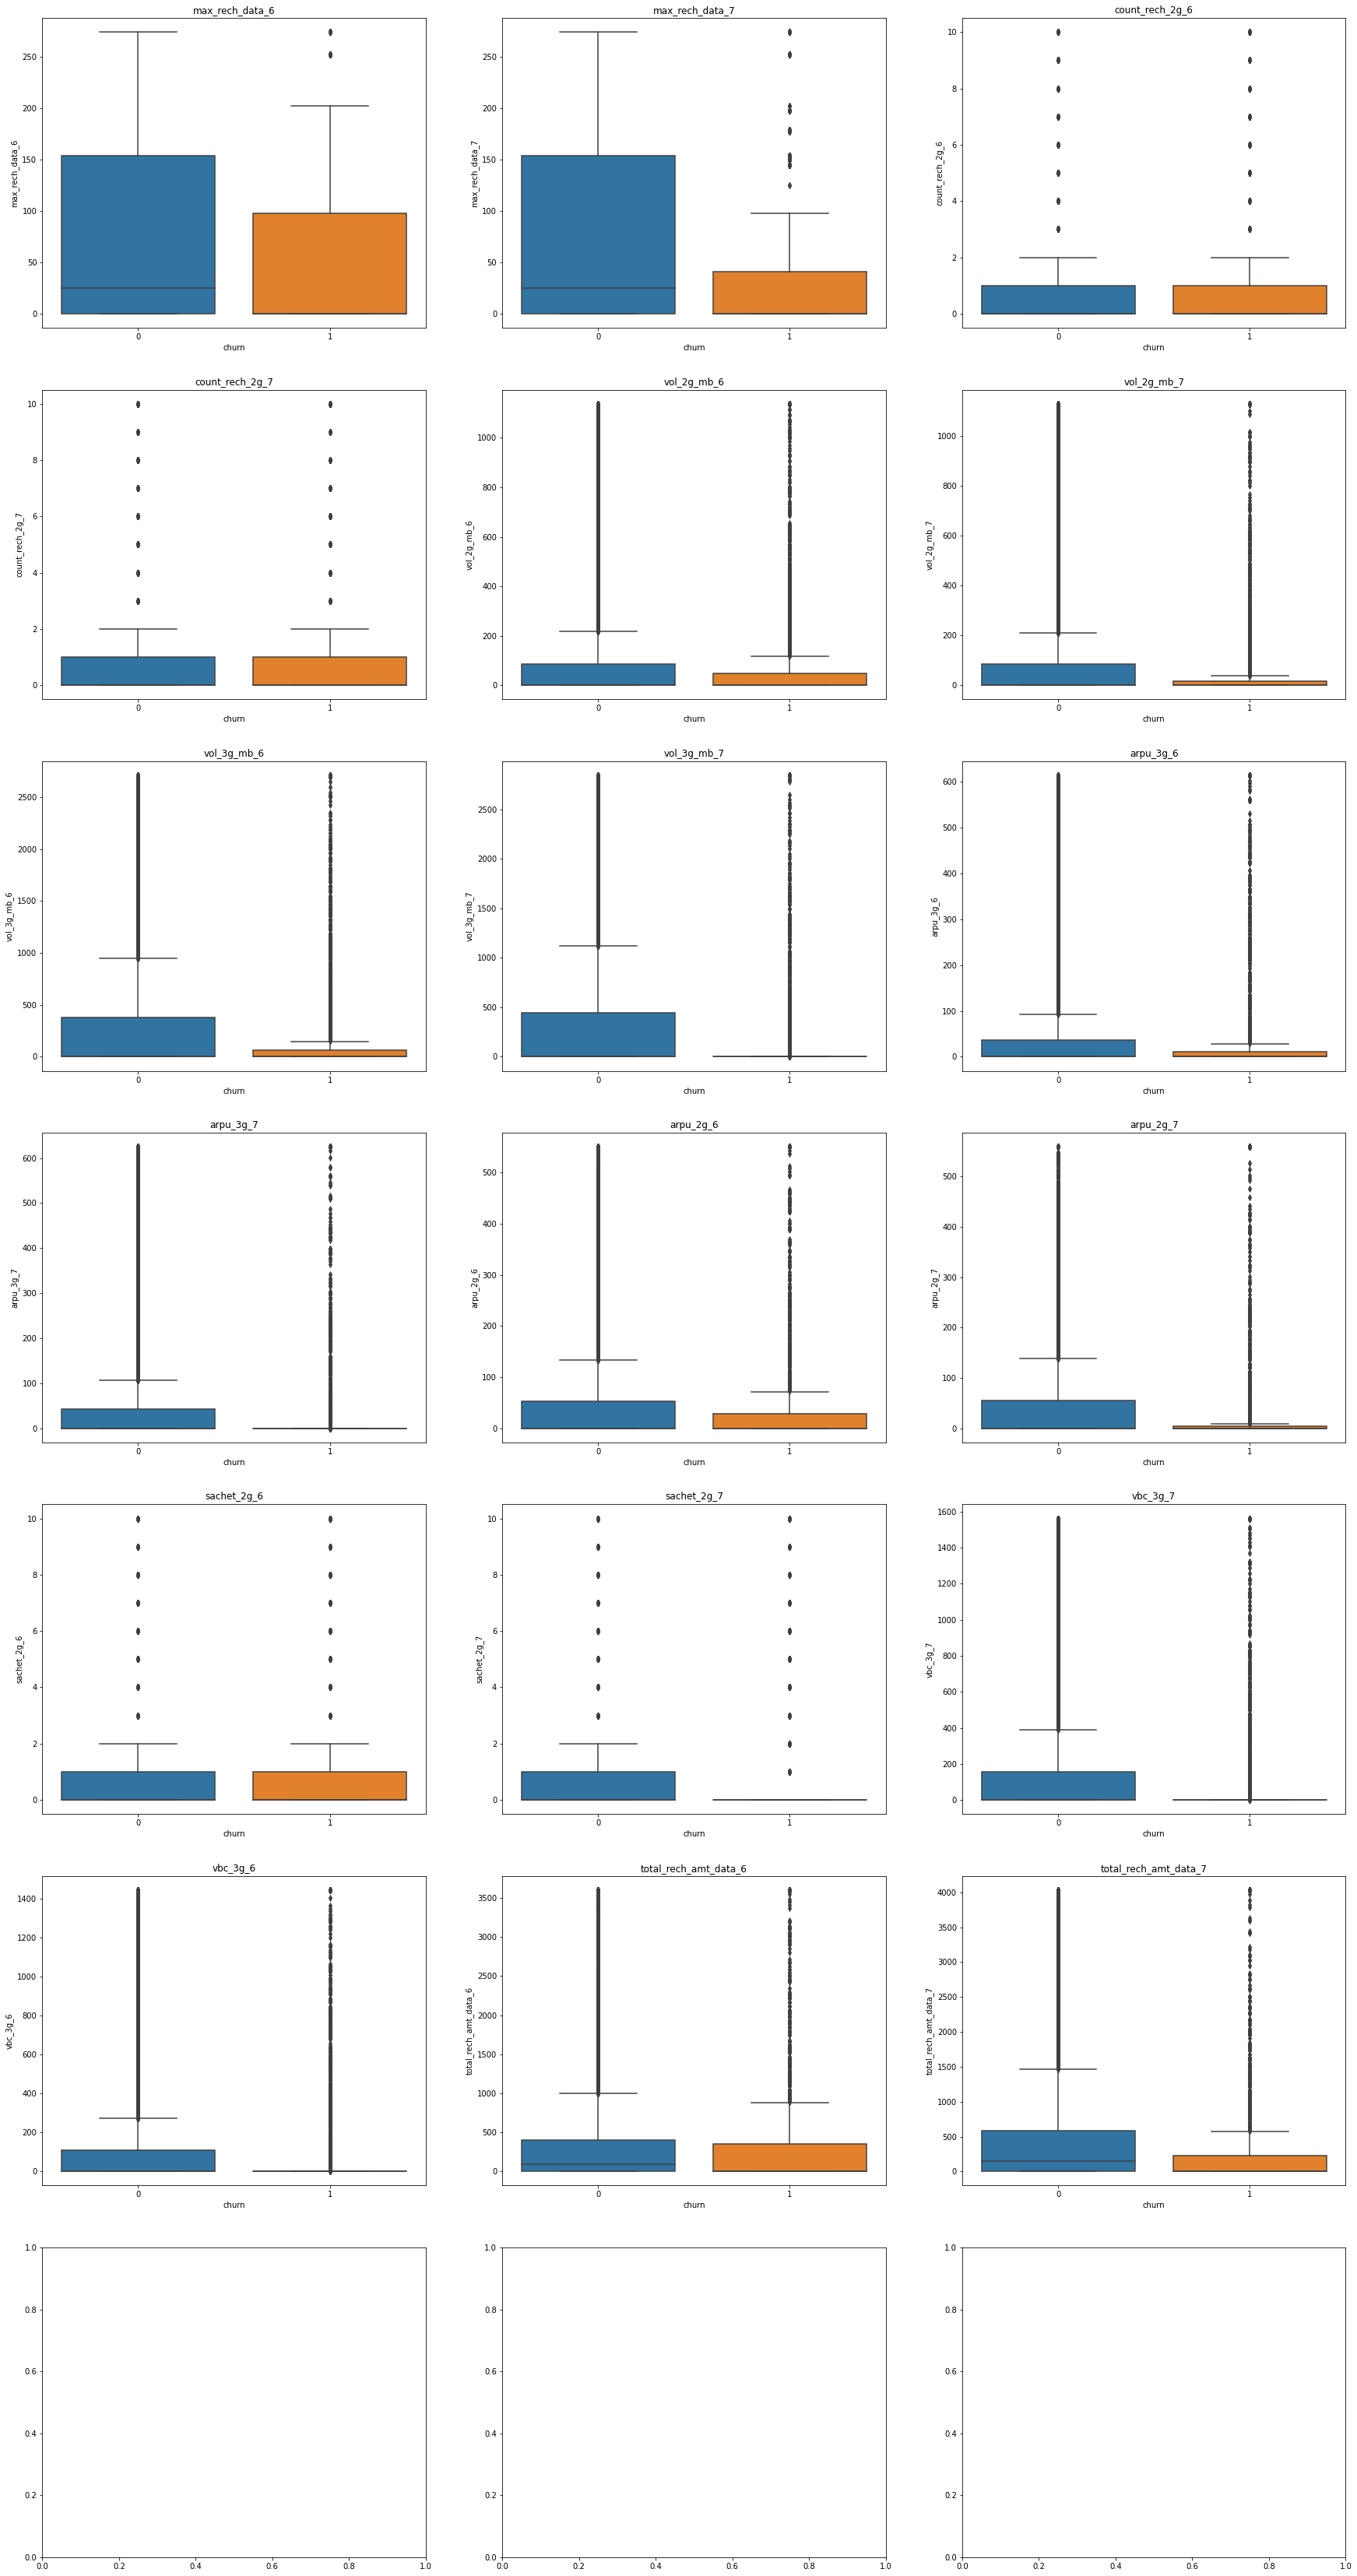

In [46]:
# Relation between data usage and customer churning for good months
# Attributes with 2g and 3g data

data_usage_gt = [i for i in data.columns if (("2g" in i or "3g" in i or 'data' in i) and "_8" not in i)]

fig, axes = plt.subplots(nrows=7, ncols = 3, figsize=(30,60))

for i in range(7):
    for j in range(3):
        if i*3 +j < len(data_usage_gt):
            sns.boxplot(x = "churn", y = data_usage_gt[i*3 +j], data=data, ax= axes[i][j])
            axes[i][j].set_title(data_usage_gt[i*3 +j])

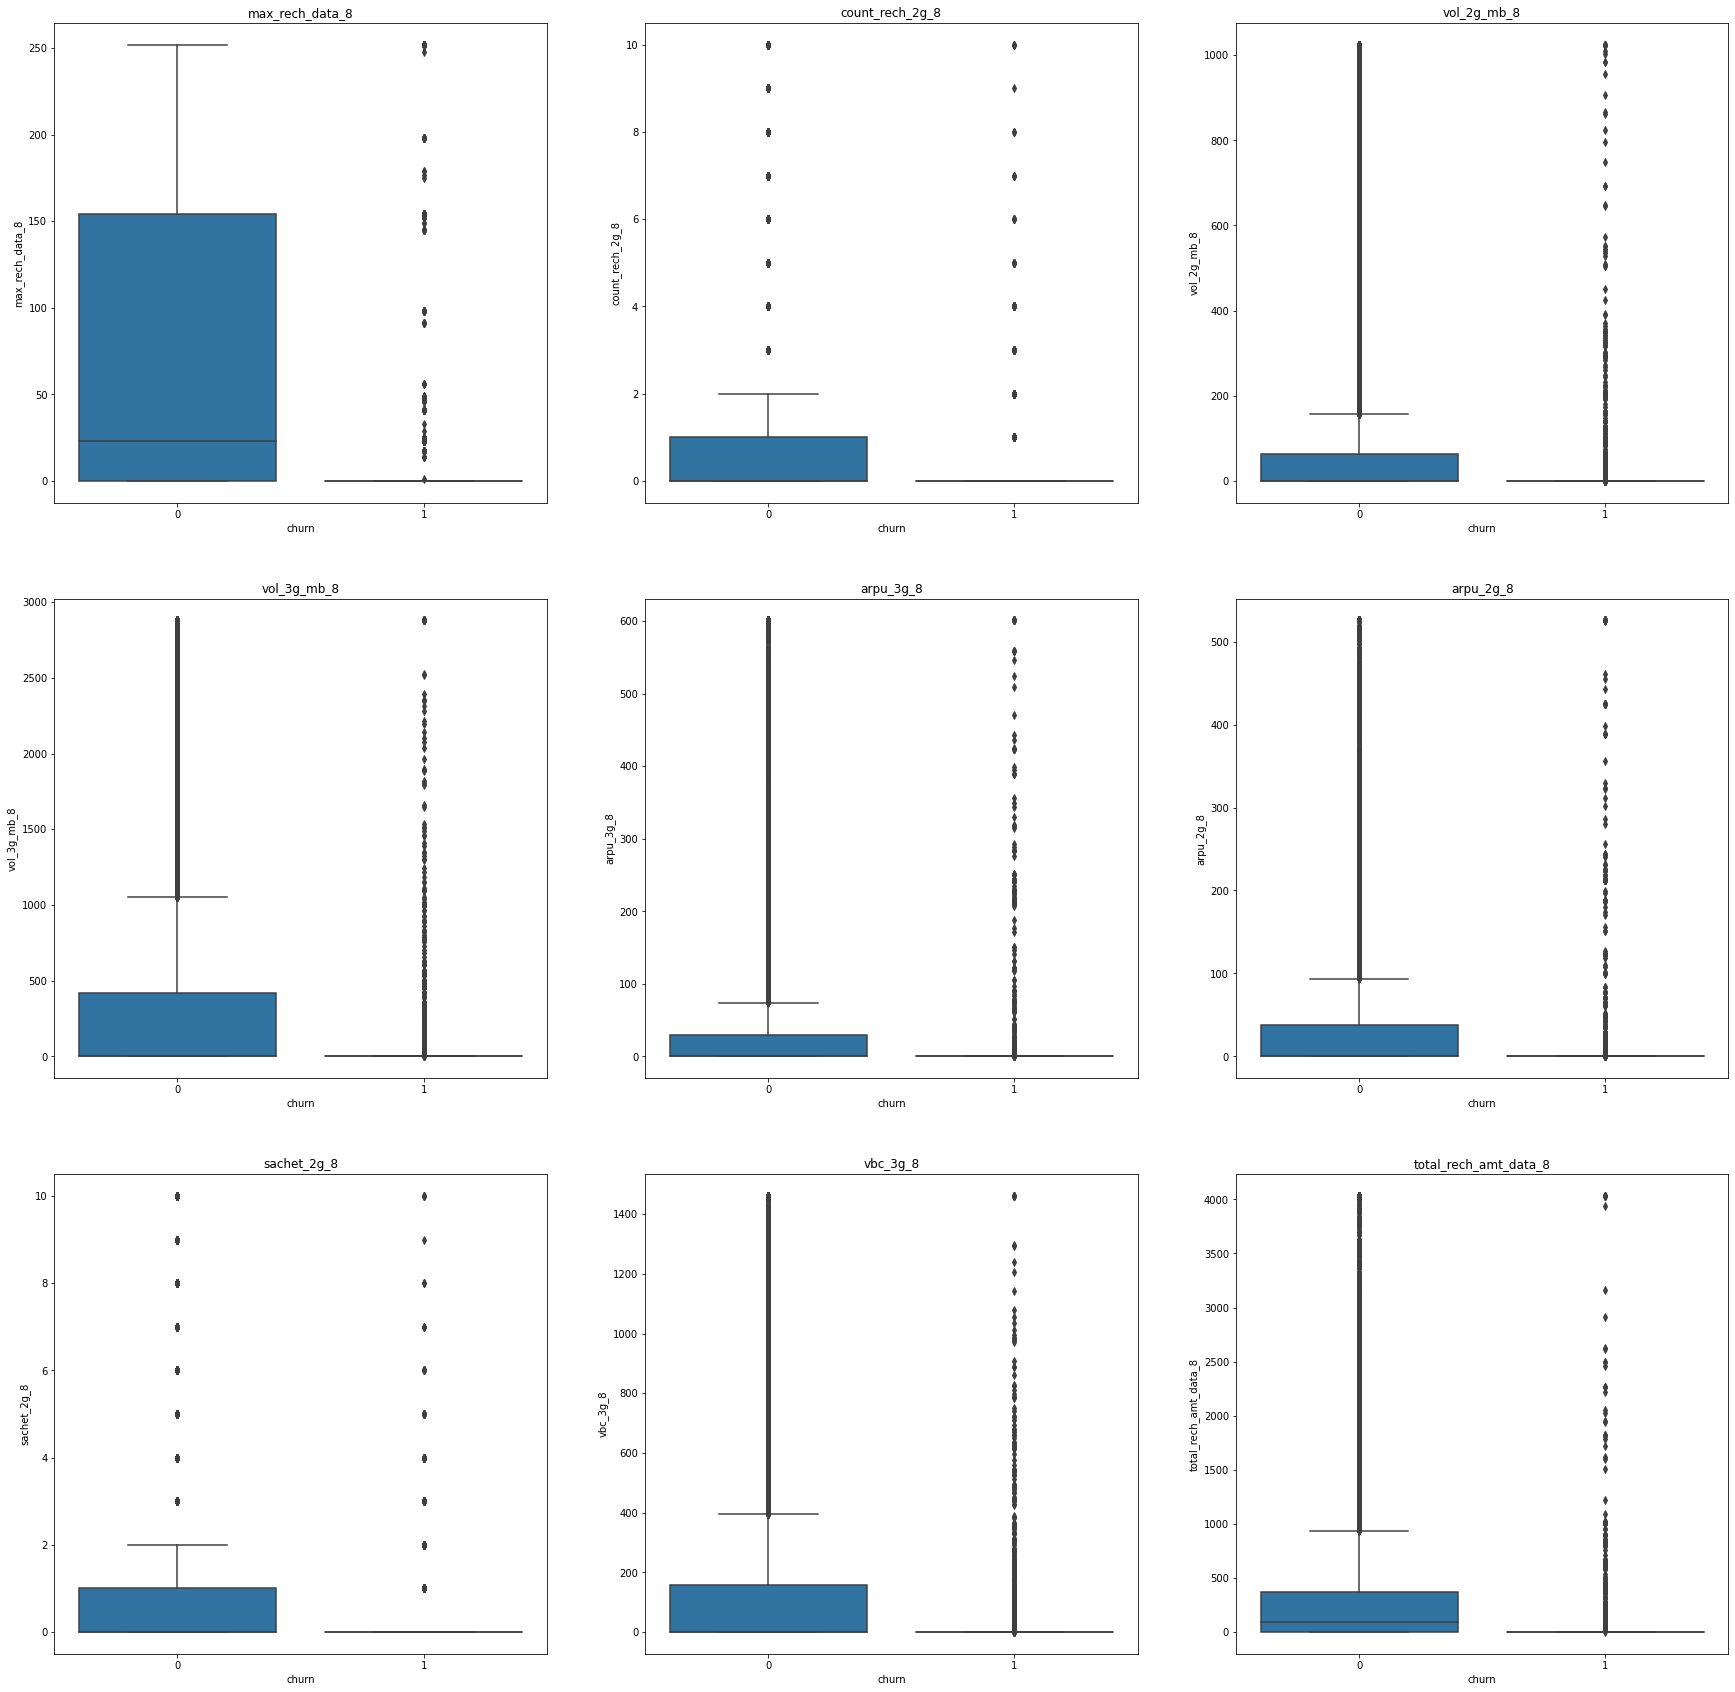

In [47]:
# Relation between data usage and customer churning for action month
# Attributes with 2g and 3g data

data_usage_8 = [i for i in data.columns if (("2g" in i or "3g" in i or 'data' in i) and "_8" in i)]

fig, axes = plt.subplots(nrows=3, ncols = 3, figsize=(30,30))

for i in range(3):
    for j in range(3):
        if i*3 +j < len(data_usage_8):
            sns.boxplot(x = "churn", y = data_usage_8[i*3 +j], data=data, ax= axes[i][j])
            axes[i][j].set_title(data_usage_8[i*3 +j])

In [48]:
data_usage = data_usage_gt + data_usage_8
data_usage.append("churn")

### We can see that the Churn customers have generally used lesser data and contributed lesser revenue compared to non-churn customers.
### Also, there is huge drop in usage from good months to the action month

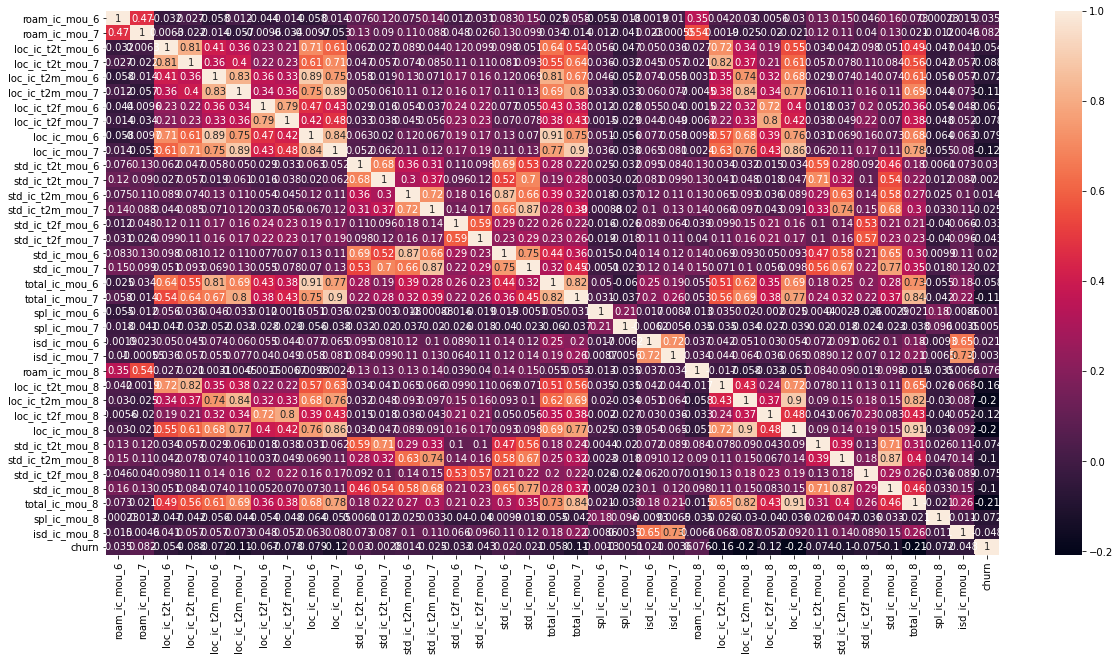

In [49]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(data[mou_ic].corr(),annot = True)
plt.show()

In [50]:
# Deleting one of the highly coorelated variables.

data.drop(["loc_ic_mou_6","loc_ic_mou_7","loc_ic_t2m_mou_6","loc_ic_t2m_mou_7"],axis=1, inplace=True)

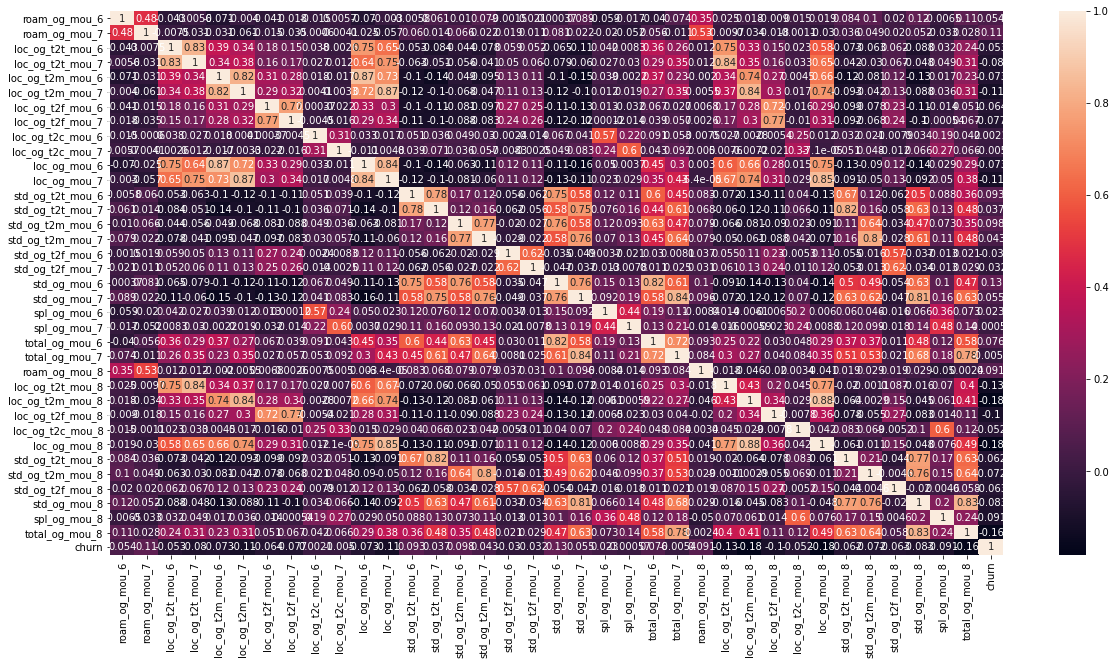

In [51]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(data[mou_og].corr(),annot = True)
plt.show()

In [52]:
# Deleting one of the highly coorelated variables.

data.drop(["std_og_mou_6","loc_og_t2m_mou_6","std_og_mou_7","loc_og_t2m_mou_7"],axis=1, inplace=True)

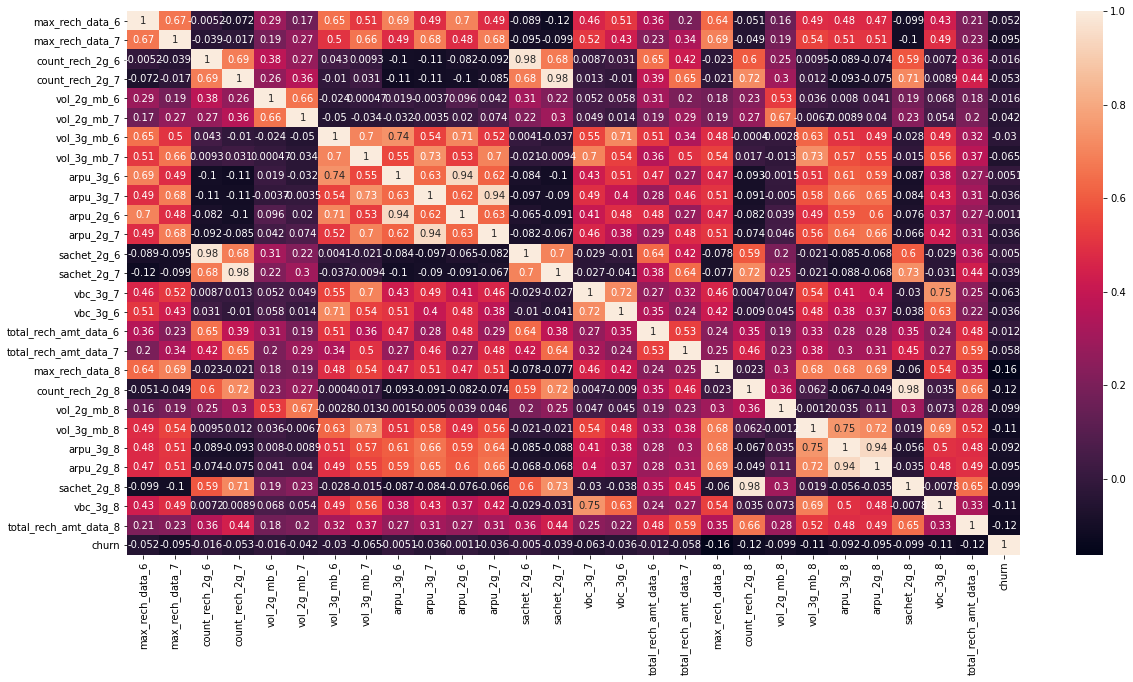

In [53]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(data[data_usage].corr(),annot = True)
plt.show()

In [54]:
data.drop(["sachet_2g_6","sachet_2g_7","sachet_2g_8","arpu_2g_6","arpu_2g_7","arpu_2g_8"],axis=1, inplace=True)

### There is very high coorelation between arpu_2g and arpu_3g. Customers use both technologies equally.
### High coorelation between "count_rech_2g" and "sachet_2g". small rechergers do it more often.

# 3. Model Building

### Creating dummy Variables

In [55]:
dummy = pd.get_dummies(["days_from_last_rech_6","days_from_last_rech_7","days_from_last_rech_8"],drop_first=True)

pd.concat([data,dummy],axis=1)

data.drop(["days_from_last_rech_6","days_from_last_rech_7","days_from_last_rech_8"],axis=1, inplace=True)
data.shape

(30001, 115)

In [297]:
X = data.drop("churn",axis=1)
y = data["churn"]


In [402]:
# Splitting the Data. Since the variables are either binary or numerical all columns are simultaneously scaled
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size =0.3, random_state = 100)

In [413]:
def metrics_(prob_predict,y):
    
    y_pred = prob_predict
    
    # Creating dtaframe with actual convertion flag and conversion probability
    y_pred_final = pd.DataFrame({'Conversion':y.values, 'Conversion_Prob':y_pred})
    y_pred_final['CustID'] = y.index
    
    # Let's create columns with different probability cutoffs 
    numbers = [0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in numbers:
        y_pred_final[i]= y_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

    num = [0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_pred_final.Conversion, y_pred_final[i] )
        
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()
    
    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y, prob_predict)
    # Use AUC function to calculate the area under the curve of precision recall curve

    auc_precision_recall = auc(recall, precision)
    print("AUC for Precision_Recall Curve is : {:.3f}".format(auc_precision_recall))

    Precision = plt.plot(thresholds, precision[:-1], "g-")
    Recall = plt.plot(thresholds, recall[:-1], "r-")
    plt.xlabel('Prob')
    plt.ylabel('Precision_Recall')
    plt.title("Precision_Recall and alpha")
    plt.legend(['Precision', 'Recall'], loc='lower right')
    plt.show()

    plt.plot(recall, precision)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision and Recall")
    plt.legend(['Precision_Recall_Curve(AUC={:.2f})'.format(auc_precision_recall)], loc='lower right')
    plt.show()
    return y_pred_final

## 1. XG Boost with Decision Tree Classifier

### Describe the upsampling through imblearn pipeline

In [145]:
# Import the required libraries and functions
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

# The parameter names for paramg_rid for gridsearchcv should be preceded with the model__ for passing it through the pipeline

params = {
    'xgbclassifier__min_child_weight':[3,5,7],
    'xgbclassifier__n_estimators':range(50,210,50),
    'xgbclassifier__gamma':[0.1,1,5],
    'xgbclassifier__max_depth': [3,5,6]
}

# f2 score is considered for scoring in gridsearchcv to give higher weightage to recall over precision score

scorer = metrics.make_scorer(metrics.fbeta_score, beta=2)

# Initiate classifier object in the pipeline along with oversampling
# Passing the train data through the SMOTE for model training-crossvalidation ensures that the model is trained on the 
# oversampled balanced data but validated on the actual imbalanced data

imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              XGBClassifier( learning_rate =0.1,
                                            subsample=0.6,
                                            colsample_bytree=0.8,
                                            objective= 'binary:logistic',
                                            nthread = 4,
                                            reg_alpha = .1,
                                            seed=27,random_state = 13))



model_XG = GridSearchCV(imba_pipeline,
                        param_grid= params,
                        scoring=scorer,n_jobs=4,iid=False, cv=5)



In [146]:
# Fit the model to train data
%%time
model_XG.fit(X_train,y_train)

[13:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1h 4min 43s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=0.1,
                                                      max_delta_step=None,
                                                      max_depth=None,
                     

In [148]:
# Parameters of the best model
model_XG.best_params_

{'xgbclassifier__gamma': 1,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__n_estimators': 50}

In [149]:
# Best f2 score obtained
model_XG.best_score_

0.6525056345821089

In [150]:
# CV Results
cv_results = pd.DataFrame(model_XG.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__gamma,param_xgbclassifier__max_depth,param_xgbclassifier__min_child_weight,param_xgbclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.631637,0.344623,0.037400,0.014151,0.1,3,3,50,"{'xgbclassifier__gamma': 0.1, 'xgbclassifier__...",0.659990,0.618687,0.632124,0.651507,0.651068,0.642675,0.015067,20
1,12.557321,0.053292,0.030006,0.006170,0.1,3,3,100,"{'xgbclassifier__gamma': 0.1, 'xgbclassifier__...",0.645856,0.613283,0.636264,0.662939,0.641026,0.639874,0.016057,36
2,18.897661,0.583933,0.029876,0.014101,0.1,3,3,150,"{'xgbclassifier__gamma': 0.1, 'xgbclassifier__...",0.631929,0.606984,0.628523,0.663741,0.629467,0.632129,0.018175,42
3,26.528083,0.224408,0.036426,0.007535,0.1,3,3,200,"{'xgbclassifier__gamma': 0.1, 'xgbclassifier__...",0.625355,0.596382,0.614237,0.661642,0.630252,0.625574,0.021464,60
4,7.328432,0.056113,0.032401,0.007003,0.1,3,5,50,"{'xgbclassifier__gamma': 0.1, 'xgbclassifier__...",0.656331,0.618661,0.632124,0.656823,0.646310,0.642050,0.014737,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,58.560523,0.933866,0.046949,0.014366,5,6,5,200,"{'xgbclassifier__gamma': 5, 'xgbclassifier__ma...",0.585424,0.541344,0.586826,0.635668,0.605263,0.590905,0.030701,106
104,16.651191,0.194216,0.051794,0.011792,5,6,7,50,"{'xgbclassifier__gamma': 5, 'xgbclassifier__ma...",0.650000,0.620861,0.635008,0.672292,0.635917,0.642816,0.017384,19
105,28.753637,1.845297,0.040627,0.012497,5,6,7,100,"{'xgbclassifier__gamma': 5, 'xgbclassifier__ma...",0.625724,0.586881,0.606500,0.668772,0.623570,0.622289,0.027118,67
106,36.670929,0.568366,0.042800,0.012687,5,6,7,150,"{'xgbclassifier__gamma': 5, 'xgbclassifier__ma...",0.609900,0.566038,0.592222,0.652428,0.616319,0.607381,0.028477,83


### Best model with the highest recall_score

### Plotting different metrics curves for the training data

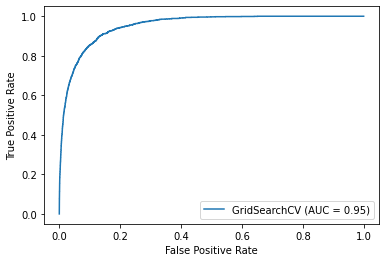

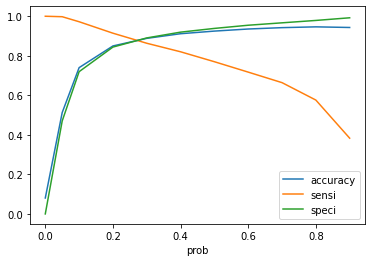

AUC for Precision_Recall Curve is : 0.695


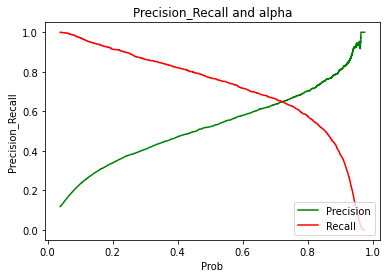

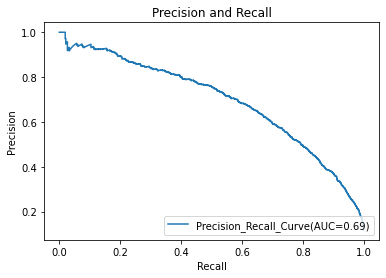

In [414]:
plot_roc_curve(model_XG, X_train, y_train, drop_intermediate=False)
plt.show()

prob_train = model_XG.predict_proba(X_train)[:,1]

y_train_pred_final = metrics_(prob_train,y_train)


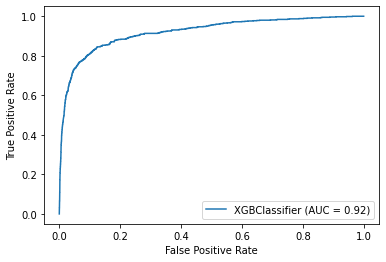

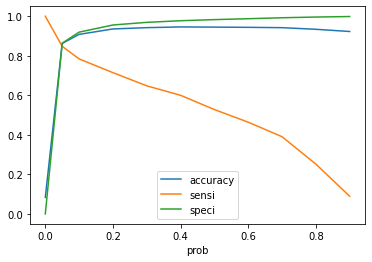

AUC for Precision_Recall Curve is : 0.667


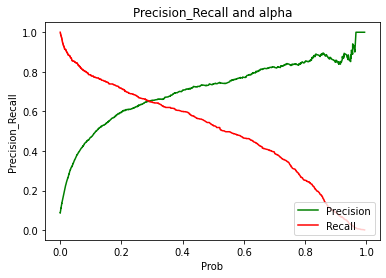

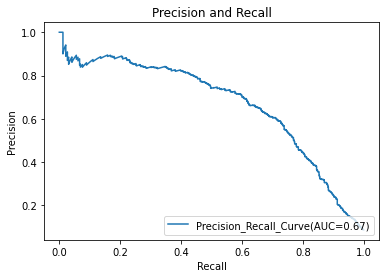

In [415]:
plot_roc_curve(xgb, X_test, y_test, drop_intermediate=False)
plt.show()

prob_test = xgb.predict_proba(X_test)[:,1]

y_test_pred = metrics_(prob_test,y_test)


## We Can see that the metrices values havent changed considerably between training and test data. Hence, the model performance is quite generalized.

In [155]:
# Creating dtaframe with actual convertion flag and conversion probability
y_test_pred.head()

,Conversion,Conversion_Prob,CustID,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.012694,20296,1,0,0,0,0,0,0,0,0,0,0
1,1,0.109397,8279,1,1,1,0,0,0,0,0,0,0,0
2,0,0.005855,72269,1,0,0,0,0,0,0,0,0,0,0
3,0,0.013684,65602,1,0,0,0,0,0,0,0,0,0,0
4,1,0.791685,42758,1,1,1,1,1,1,1,1,1,0,0


## Since the objective of the model is to identify the potential churn customers. A threshold probability of 0.1 is considered to maximize Recall.

In [421]:
y_test_pred['final_predicted'] = y_test_pred.Conversion_Prob.map( lambda x: 1 if x > 0.05 else 0)

y_test_pred.head()

,Conversion,Conversion_Prob,CustID,0.0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.012694,20296,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0.109397,8279,1,1,1,0,0,0,0,0,0,0,0,1
2,0,0.005855,72269,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0.013684,65602,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0.791685,42758,1,1,1,1,1,1,1,1,1,0,0,1


## Metrics beyond accuracy

In [422]:
# Visualize the classification report for model prediction over test data
from sklearn.metrics import classification_report

print(classification_report(y_test_pred.Conversion, y_test_pred.final_predicted ))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8251
           1       0.36      0.85      0.51       750

    accuracy                           0.86      9001
   macro avg       0.67      0.86      0.71      9001
weighted avg       0.93      0.86      0.89      9001



In [423]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_test_pred.Conversion, y_test_pred.final_predicted )
confusion

array([[7127, 1124],
       [ 114,  636]], dtype=int64)

In [424]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [425]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.848

In [426]:
# Let us calculate specificity
TN / float(TN+FP)

0.8637740879893346

In [427]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.13622591201066536


In [428]:
# positive predictive value 
print (TP / float(TP+FP))

0.3613636363636364


In [429]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9842563181880956


## 2. Random Forest Model

In [170]:
# Import the required libraries and functions for building Random forest model
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

## Hyper Parameter Tuning for Random Forest Model

In [171]:
### Hyper Parameter Tuning for Random Forest Model

fold = KFold(n_splits=5, shuffle=True, random_state=42)

# The parameter names for paramg_rid for gridsearchcv should be preceded with the model__ for passing it through the pipeline
params = {"randomforestclassifier__max_depth": [3,5,7],
          "randomforestclassifier__min_samples_leaf" :[0.05,0.1,0.3],
          "randomforestclassifier__max_features":[0.1,0.25,0.4],
          "randomforestclassifier__n_estimators":[50,100,150],
          "randomforestclassifier__max_samples" : [0.2,0.3,0.4]}


# f2 score is considered for scoring in gridsearchcv to give higher weightage to recall over precision score

scorer = metrics.make_scorer(metrics.fbeta_score, beta=2)

# Initiate classifier object in the pipeline along with oversampling
# Passing the train data through the SMOTE for model training-crossvalidation ensures that the model is trained on the 
# oversampled balanced data but validated on the actual imbalanced data

imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(oob_score = True,criterion = 'entropy',random_state = 13))

RF_cv = GridSearchCV(imba_pipeline,
                    param_grid=params,
                    n_jobs=-1,
                    cv = fold,
                    scoring= scorer,
                    verbose = 1,
                    return_train_score=True)


In [172]:
%%time
# Fit the gridsearch object on the train data from PCA
RF_cv.fit(X_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 15.4min finished


Wall time: 15min 29s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(criterion='entropy',
                                                               oob_score=True,
                                                               random_state=13))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [3, 5, 7],
                         'randomforestclassifier__max_features': [0.1, 0.25,
                                                                  0.4],
                         'randomforestclassifier__max_samples': [0.2, 0.3, 0.4],
                         'randomforestclassifier__min_samples_leaf': [0.05, 0.1,
                                                                      0.3],
                         'randomforestclassifier__n_estimators'

In [173]:
# score of best model
RF_cv.best_score_

0.5914169579714635

### Best model with the highest recall_score

In [174]:
# Best model
RF2 = RF_cv.best_estimator_
RF2

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        max_features=0.25, max_samples=0.4,
                                        min_samples_leaf=0.05, oob_score=True,
                                        random_state=13))])

In [175]:
# CV Results
cv_results = pd.DataFrame(RF_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__max_samples,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.531671,0.033624,0.046000,0.004899,3,0.1,0.2,0.05,50,"{'randomforestclassifier__max_depth': 3, 'rand...",...,0.564980,0.016675,55,0.573237,0.569620,0.560616,0.561572,0.568654,0.566740,0.004866
1,4.206860,0.018204,0.066414,0.010028,3,0.1,0.2,0.05,100,"{'randomforestclassifier__max_depth': 3, 'rand...",...,0.562642,0.013986,58,0.564978,0.563198,0.559143,0.560896,0.565423,0.562728,0.002398
2,6.500975,0.134311,0.109801,0.014078,3,0.1,0.2,0.05,150,"{'randomforestclassifier__max_depth': 3, 'rand...",...,0.560143,0.014775,61,0.565563,0.559761,0.556376,0.558511,0.566900,0.561422,0.004095
3,2.103007,0.111898,0.023400,0.003072,3,0.1,0.2,0.1,50,"{'randomforestclassifier__max_depth': 3, 'rand...",...,0.122571,0.150127,208,0.000000,0.000000,0.000000,0.303372,0.304735,0.121621,0.148956
4,3.306881,0.107303,0.038601,0.002416,3,0.1,0.2,0.1,100,"{'randomforestclassifier__max_depth': 3, 'rand...",...,0.304456,0.008475,136,0.303542,0.308465,0.302518,0.303372,0.304735,0.304526,0.002092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,10.067885,0.160429,0.062001,0.002367,7,0.4,0.4,0.1,100,"{'randomforestclassifier__max_depth': 7, 'rand...",...,0.559643,0.016776,64,0.564642,0.559843,0.556201,0.556461,0.565504,0.560530,0.003935
239,15.218709,0.466934,0.073802,0.025040,7,0.4,0.4,0.1,150,"{'randomforestclassifier__max_depth': 7, 'rand...",...,0.558607,0.016739,70,0.563566,0.560554,0.556269,0.556202,0.566354,0.560589,0.004000
240,1.779837,0.058217,0.027400,0.000489,7,0.4,0.4,0.3,50,"{'randomforestclassifier__max_depth': 7, 'rand...",...,0.241956,0.121208,190,0.303542,0.308465,0.000000,0.303372,0.304735,0.244023,0.122025
241,2.814068,0.044360,0.046800,0.002713,7,0.4,0.4,0.3,100,"{'randomforestclassifier__max_depth': 7, 'rand...",...,0.304456,0.008475,136,0.303542,0.308465,0.302518,0.303372,0.304735,0.304526,0.002092


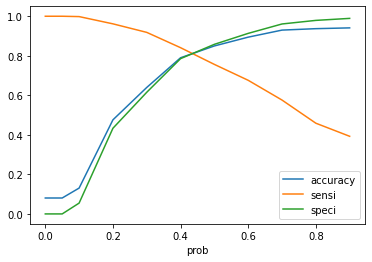

AUC for Precision_Recall Curve is : 0.548


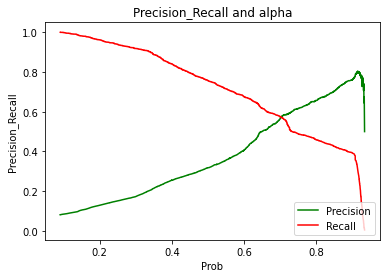

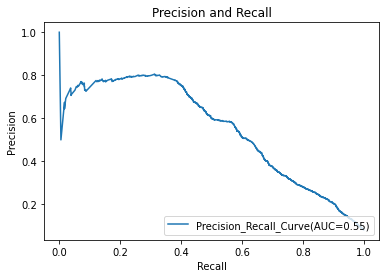

In [431]:
# Make predictions using the best model

prob_train = RF2.predict_proba(X_train)[:,1]

y_train_pred = metrics_(prob_train,y_train)


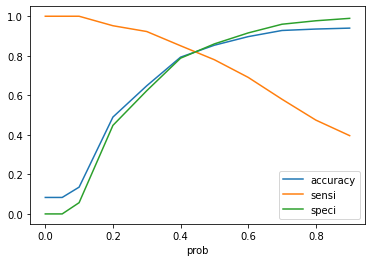

AUC for Precision_Recall Curve is : 0.559


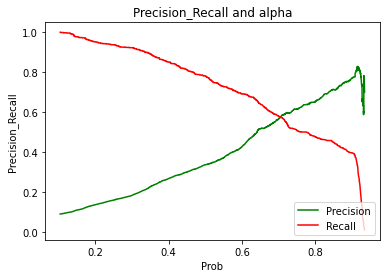

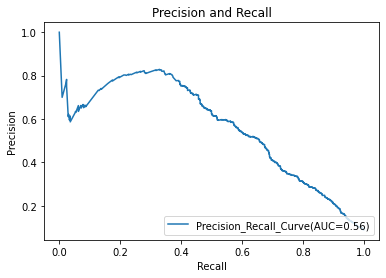

In [432]:
prob_test = RF2.predict_proba(X_test)[:,1]

y_test_pred = metrics_(prob_test,y_test)

## We Can see that the metrices values havent changed considerably between training and test data. Hence, the model performance is quite generalized.

## Since the objective of the model is to identify the potential churn customers. A threshold probability of 0.4 is considered to maximize Recall.

In [434]:
print(metrics.recall_score(y_train,y_train_pred[0.4]))
print(metrics.recall_score(y_test,y_test_pred[0.4]))

0.8409225310467179
0.8506666666666667


In [183]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_test, y_test_pred[0.4] )
confusion

array([[6500, 1751],
       [ 112,  638]], dtype=int64)

## Metrics beyond accuracy

In [184]:
# Classification report for the best model applied over the test data
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred[0.4]))

              precision    recall  f1-score   support

           0       0.98      0.79      0.87      8251
           1       0.27      0.85      0.41       750

    accuracy                           0.79      9001
   macro avg       0.63      0.82      0.64      9001
weighted avg       0.92      0.79      0.84      9001



In [185]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [186]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8506666666666667

In [187]:
# Let us calculate specificity
TN / float(TN+FP)

0.7877832989940613

In [188]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.21221670100593867


In [189]:
# positive predictive value 
print (TP / float(TP+FP))

0.2670573461699456


In [190]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9830611010284331


### Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

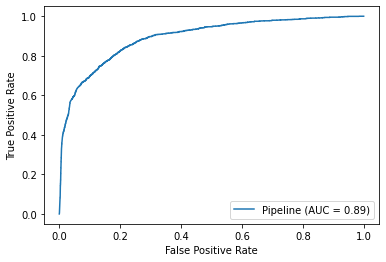

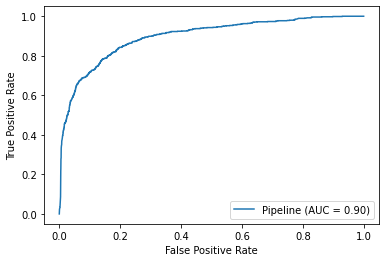

In [192]:
plot_roc_curve(RF2, X_train, y_train, drop_intermediate=False)
plt.show()

plot_roc_curve(RF2, X_test, y_test, drop_intermediate=False)
plt.show()

## - The Best Model for Deployment

For selecting the best model, Recall_score of the "Churn" cases is considered.
Since the objective of developing this prediction model is to identify as many customers as possible who could probably "Churn" and leave the network. A higher recall score means that the model is able identify a higher % of customers who could possibly "Churn".

The Recall_Score for both XGboost and RandomForest models is same i.e 85%, but XGboost has a better Precision i.e. 36% compared to 27% of Randomforest model, corresponding to the same Recall_score. Hence, the cost of deployment of XGboost model is less and is the proposed model for deployment.

However, both models should be tested on out of time data and the decision for final deployment should be based on its outcome.

# 4. The most Important predictor attributes

## Logistic Regression RFE + Lasso
### To identify the most important predictor variables, a logistic Regression model is built. For feature selection RFE is followed by Lasso regularisation

In [435]:
data_lasso = data.copy()
data_lasso.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,churn,av_amt_per_rech_6,av_amt_per_rech_7,av_amt_per_rech_8
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,30.40,0.00,101.20,252.0,252.0,252.0,1,90.500000,84.000000,126.000000
7,1069.180,1349.850,1659.130,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,57.74,19.38,18.74,0.0,0.0,0.0,1,252.000000,158.000000,303.000000
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,21.03,910.65,122.16,0.0,354.0,207.0,0,23.000000,28.619048,8.571429
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0.00,0.00,0.00,0.0,0.0,0.0,0,27.272727,26.153846,26.592593
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,40.45,51.86,0.00,0.0,712.0,540.0,0,5.000000,90.800000,109.750000


#### Performing min max scalar

In [436]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [437]:
data_lasso.iloc[:,:] = scaler.fit_transform(data_lasso.values)
data_lasso.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,churn,av_amt_per_rech_6,av_amt_per_rech_7,av_amt_per_rech_8
0,0.099299,0.106753,0.128865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020807,0.000000,0.069965,0.07,0.062500,0.062500,1.0,0.346154,0.305455,0.415842
7,0.648781,0.815925,1.000000,0.034435,0.031127,0.031600,0.247005,0.308509,0.188406,0.076308,...,0.039520,0.012401,0.012956,0.00,0.000000,0.000000,1.0,1.000000,0.574545,1.000000
8,0.213593,0.280078,0.082792,0.246289,0.199825,0.021200,0.051566,0.043859,0.078898,0.000000,...,0.014394,0.582712,0.084456,0.00,0.087798,0.051339,0.0,0.072874,0.104069,0.028289
21,0.299143,0.346013,0.384394,0.060970,0.075204,0.051453,0.412881,0.487753,0.568489,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.090173,0.095105,0.087764
23,0.021752,0.093683,0.221180,0.029148,0.028838,0.020293,0.046527,0.048608,0.119023,0.000000,...,0.027686,0.033184,0.000000,0.00,0.176587,0.133929,0.0,0.000000,0.330182,0.362211


### Splitting the data into test and train set

In [438]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data_lasso, train_size = 0.7, test_size = 0.3, random_state = 100)

In [439]:
y_train = df_train.pop('churn')
X_train = df_train

In [440]:
y_test = df_test.pop('churn')
X_test = df_test

### Building the model

### Using RFE to creat initial model keeping 50 most significant variables

In [441]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [442]:
lm = LogisticRegression(class_weight={1:0.9,0:0.1})
lm.fit(X_train, y_train)
# define the method
rfe = RFE(lm,50)
# fit the model
rfe = rfe.fit(X_train, y_train)

In [443]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', False, 26),
 ('onnet_mou_6', False, 19),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 21),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 60),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 30),
 ('roam_og_mou_6', False, 63),
 ('roam_og_mou_7', False, 7),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 53),
 ('loc_og_t2t_mou_7', False, 42),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 22),
 ('loc_og_t2f_mou_7', False, 3),
 ('loc_og_t2f_mou_8', False, 4),
 ('loc_og_t2c_mou_6', False, 32),
 ('loc_og_t2c_mou_7', False, 27),
 ('loc_og_t2c_mou_8', False, 28),
 ('loc_og_mou_6', False, 37),
 ('loc_og_mou_7', False, 13),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 23),
 ('std_og_t2t_mou_7', True, 1),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m_mou_6', False, 38),
 ('std_og_t2m_mou_7', False,

In [444]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_7', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'std_og_mou_8', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'total_rech_num_8', 'total_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_8', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_8',
       'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'aon', 'vbc_3g_8',
       'total_rech_amt_data_8', 'av_amt_per_rech_7', 'av_amt_per_rech_8'],
      dtype='object')

In [445]:
#X_train.columns[~rfe.support_]

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

# Add a constant
X_train = X_train[col]
X_test= X_test[col]


### Hyperparameter tuning to identify the best model

In [446]:
# grid search CV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
grid_values = {'lasso__alpha': [0.0001,0.001,0.005,0.01,0.02]}

# grid search
# lasso model

scorer = metrics.make_scorer(metrics.fbeta_score, beta=2)

# The scoring metrices like accuracy, recall etc. require class labels as prediction outcome.
# But, lasso based model gives probability as the output and hence these metrices can't be used for validation.
# AUC_precision_recall_curve provides a good alternative to be used in this case.

def my_scorer(y_test,y_pred):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

scorer = metrics.make_scorer(my_scorer,greater_is_better=True)

imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              Lasso(random_state = 13))

# grid search


model_cv = GridSearchCV(imba_pipeline, param_grid = grid_values, 
                        scoring= scorer, 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train) 
        


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    5.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('lasso', Lasso(random_state=13))]),
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.005, 0.01, 0.02]},
             return_train_score=True, scoring=make_scorer(my_scorer),
             verbose=1)

In [447]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.293792,0.035629,0.002801,3.999718e-04,0.0001,{'lasso__alpha': 0.0001},0.522775,0.487180,0.508553,0.497869,...,0.497973,0.016989,5,0.497612,0.506515,0.496312,0.500678,0.511597,0.502543,0.005734
1,0.267415,0.024642,0.002801,7.491821e-04,0.001,{'lasso__alpha': 0.001},0.526581,0.502775,0.506186,0.501567,...,0.502608,0.016126,4,0.501986,0.509109,0.502760,0.504175,0.513878,0.506382,0.004493
2,0.189204,0.001720,0.002605,4.833029e-04,0.005,{'lasso__alpha': 0.005},0.536361,0.518783,0.510838,0.524371,...,0.516936,0.014031,2,0.513018,0.523221,0.518951,0.516173,0.527378,0.519748,0.005079
3,0.195001,0.003848,0.003207,3.959077e-04,0.01,{'lasso__alpha': 0.01},0.538435,0.516597,0.500891,0.527859,...,0.516999,0.014740,1,0.512302,0.524215,0.518843,0.516842,0.522736,0.518988,0.004259
4,0.193999,0.009143,0.002001,8.996946e-07,0.02,{'lasso__alpha': 0.02},0.513983,0.511785,0.483605,0.500426,...,0.505128,0.012023,3,0.499536,0.516651,0.501597,0.506875,0.502632,0.505458,0.006087


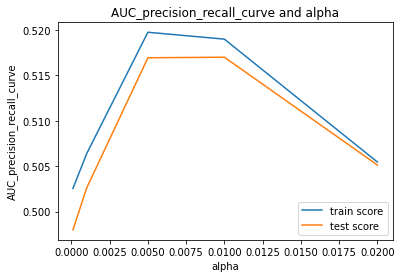

In [448]:
# plotting mean test and train scoes with alpha 
cv_results['param_lasso__alpha'] = cv_results['param_lasso__alpha']
# plotting
plt.plot(cv_results['param_lasso__alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_lasso__alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('AUC_precision_recall_curve')
plt.title("AUC_precision_recall_curve and alpha")
plt.legend(['train score', 'test score'], loc='lower right')
plt.show()

In [470]:
from sklearn import metrics

lasso = model_cv.best_estimator_

lasso

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('lasso', Lasso(alpha=0.01, random_state=13))])

## The best model is corresponding to alpha=0.01

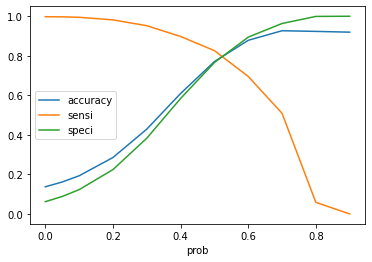

AUC for Precision_Recall Curve is : 0.517


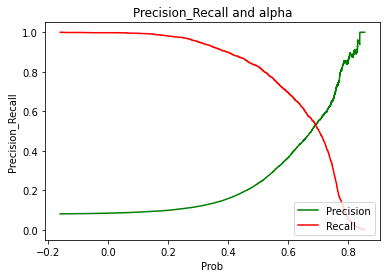

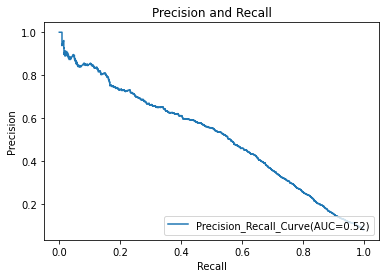

In [469]:
# Make predictions using the best model

prob_train = lasso.predict(X_train)

y_train_pred = metrics_(prob_train,y_train)

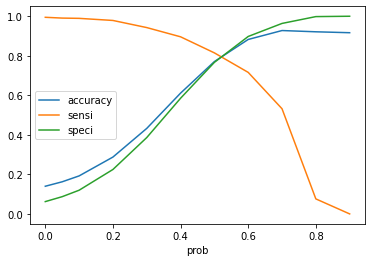

AUC for Precision_Recall Curve is : 0.531


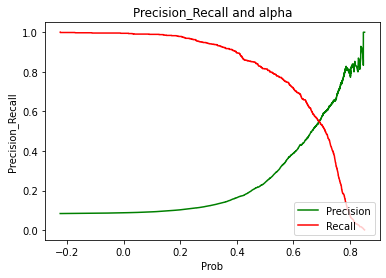

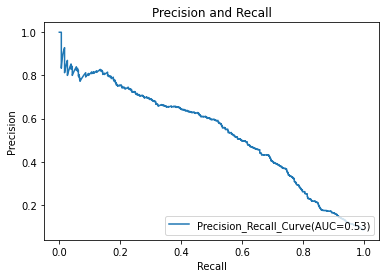

In [471]:
prob_test = lasso.predict(X_test)

y_test_pred = metrics_(prob_test,y_test)

From the curve above, 0.5 is the optimum point to consider as the threshold probability.

In [472]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_test_pred.Conversion, y_test_pred[0.5])

0.770692145317187

In [473]:
confusion2 = metrics.confusion_matrix(y_test_pred.Conversion, y_test_pred[0.5])
confusion2

array([[6326, 1925],
       [ 139,  611]], dtype=int64)

In [474]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [475]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8146666666666667

In [476]:
# Let us calculate specificity
TN / float(TN+FP)

0.7666949460671434

In [477]:
from sklearn.metrics import classification_report

print(classification_report(y_test_pred.Conversion, y_test_pred[0.5]))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      8251
         1.0       0.24      0.81      0.37       750

    accuracy                           0.77      9001
   macro avg       0.61      0.79      0.62      9001
weighted avg       0.92      0.77      0.82      9001



## Identifying the top Predictors from the model

In [391]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
mod_para_abs = [abs(x) for x in model_parameters]

rank = list(zip(mod_para_abs, cols, model_parameters))
rank1 = [x for x in rank if x[0]>0]
print(len(rank1))
sorted(rank1,reverse=True)

14


[(0.171, 'constant', 0.171),
 (0.109, 'total_rech_num_8', -0.109),
 (0.079, 'max_rech_data_8', -0.079),
 (0.067, 'av_amt_per_rech_8', -0.067),
 (0.056, 'total_og_mou_8', -0.056),
 (0.05, 'total_ic_mou_8', -0.05),
 (0.044, 'arpu_6', 0.044),
 (0.041, 'loc_ic_mou_8', -0.041),
 (0.028, 'count_rech_2g_8', -0.028),
 (0.016, 'loc_og_t2m_mou_8', -0.016),
 (0.015, 'aon', -0.015),
 (0.008, 'last_day_rch_amt_8', -0.008),
 (0.004, 'total_rech_amt_6', 0.004),
 (0.002, 'loc_ic_t2m_mou_8', -0.002)]

## Based Upon the outcome of the Logistic regression model the most important predictors of customer churn are
### - 'total_rech_num_8',    - 0.109
### - 'max_rech_data_8' ,   - 0.079
### - 'av_amt_per_rech_8' - 0.067

<AxesSubplot:xlabel='Predictor', ylabel='Coefficient_abs'>

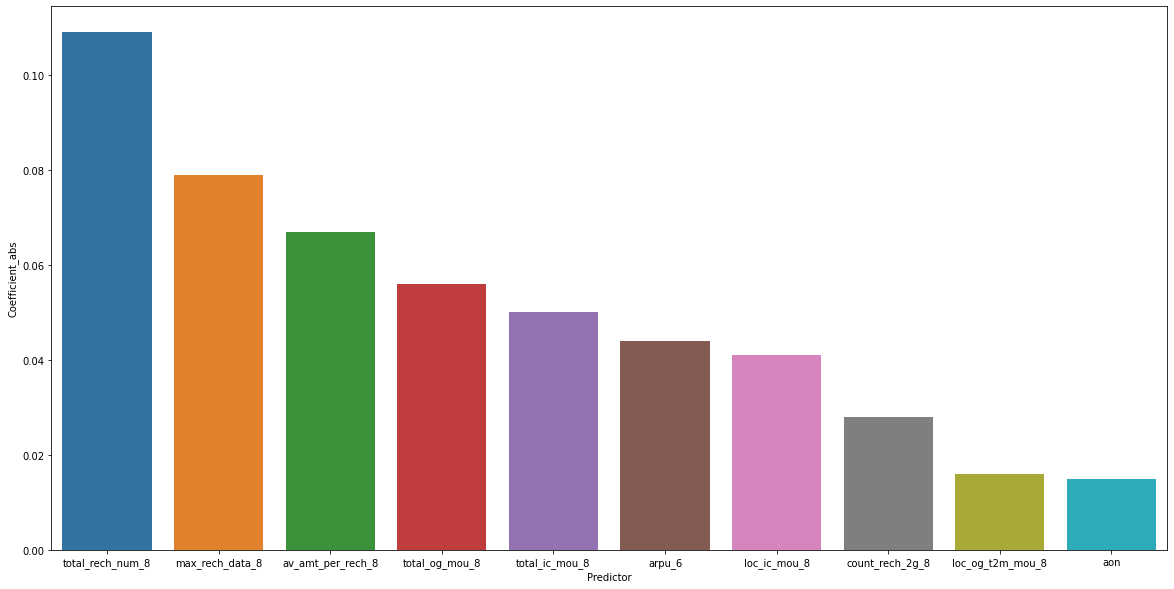

In [399]:
predictors = pd.DataFrame({'Predictor':cols, 'Coefficient_abs':mod_para_abs})
predictors.drop(0,inplace=True)
predictors
predictors.sort_values(by="Coefficient_abs", ascending=False,inplace=True)

plt.figure(figsize=(20,10))
sns.barplot(x="Predictor",y="Coefficient_abs",data=predictors[:10])


### - As could be seen that the most important predictors are of the action month and not of the good months. That implies that people take very quick decision about changing service provider. Hence, immediate action should be taken to retain the customers and the sops and offers shall be provided accordingly.
### - Since, the number of times a person does recharge inversely affects churn. People not doing recharges in the first two weeks of the month should be immidiately engaged.
### - People prefering data usage are less likely to churn as can be seen from the high negative coorelation of data recharge and churn. The data plans of the company are attractive to the customers. Company could look into more data based value added services to increase revenue.
### - In general people having lower usage are more likely to churn compared to others.